<a target="_blank" href="https://colab.research.google.com/drive/1QFx-PvN4szZJkZT-_oRqXdTF1welbPen">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

В данном ноутбуке представлены модели, которые решают задачу многоклассовой классификации на графах.<br>
Ноутбук сосотоит из пяти основных пунктов и введения.<br>
Во введении представлены графики, чтобы можно было наглядно увидеть, что требуется по задаче. Также представлено моделирование задачи, по постановке близкой к рассматриваемой. Это поиск сообществ в графах. Была первоначальная гипотеза, что с помощью кластеризации можно косвенно классифицировать узлы по классам. Но в задаче без учителя даже точность оказалось очень маленькой. В кластеры попадали узлы с разными классами.<br>
Остальные пять пунктов относятся к моделированию на синтетических данных, по характеристикам приближенным к реальным данным. Синтетические данные формируются в данном ноутбуке, анализируются и моделируются в этом ноутбуке. Как получались реальные данные, что из себя представляют с проведённым разведывательным данным и извлечениям признаком находятся в [ноутбуке с анализом реальных данных](https://colab.research.google.com/drive/11yGjzRhfroZfdZgYD4e7tJJx97OsTmI_?usp=sharing).<br>
В пунктах, относящихся к задаче многоклассовой классификации на графах было проделано согласно методологии CRYSP-DM и заданию:
- подготовка и анализ данных
- выбор моделей, построение и обучение базовых моделей (baseline)
- реализация сложной модели с помощью подбора гиперпараметров
- оценка качества моделей по выбранным метрикам
- анализ результатов и предложение об улучшении показателей
- реализация по возможности более продвинутых моделей в конце этого ноутбука.

In [ ]:
pip install optuna

# 0. Краткое введение в проблематику. Постановка задачи. Графики.

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 15  # Ещё сильнее уменьшаем количество узлов
num_clusters = 3  # Уменьшаем количество кластеров
num_attractions_per_cluster = 3  # Меньше сильных связей внутри кластера
attraction_strength = 3  # Уменьшаем вес сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [5, 5, 5]  # Равномерное распределение узлов по кластерам

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster']))  # Вероятность связи обратно пропорциональна дистанции между кластерами
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(5, 10), (5, 10)]  # Уменьшаем количество мультисвязей
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {5: ('strong'), 10: ('weak'), 2: ('multi')}  # Уменьшаем количество связей

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 5), (new_node, 10)]  # Уменьшаем количество мультисвязей
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')  # Выделяем связи от тестового узла красным цветом

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 15  # Всего 15 узлов
num_clusters = 3  # Всего три кластера
num_attractions_per_cluster = 2  # Очень мало сильных связей внутри кластера
attraction_strength = 3  # Достаточно слабый вес сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [5, 5, 5]  # Равномерное распределение узлов по кластерам

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster'])) * 0.1  # Очень маленькая вероятность внешних связей
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Очень редкие слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Очень ограниченное количество сильных связей

# Добавляем дополнительные мультисвязи
extra_edges = [(5, 10)]  # Одна единственная мультисвязь
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {5: ('strong'), 10: ('weak')}  # Минимальное количество связей

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 5)]  # Единственная мультисвязь от тестового узла
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')  # Выделяем связи от тестового узла красным цветом

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 15  # Всего 15 узлов
num_clusters = 3  # Всего три кластера
num_attractions_per_cluster = 2  # Очень мало сильных связей внутри кластера
attraction_strength = 3  # Достаточно слабый вес сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [5, 5, 5]  # Равномерное распределение узлов по кластерам

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster'])) * 0.1  # Очень маленькая вероятность внешних связей
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Очень редкие слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Очень ограниченное количество сильных связей

# Добавляем дополнительные мультисвязи
extra_edges = [(5, 10)]  # Одна единственная мультисвязь
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {5: ('strong'), 10: ('weak')}  # Минимальное количество связей

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 5)]  # Единственная мультисвязь от тестового узла
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф БЕЗ тестового узла
plt.subplot(4, 1, 1)
sub_G = G.copy()
sub_G.remove_node(new_node)  # Создаем копию графа без тестового узла

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(sub_G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(sub_G, pos, node_color=node_colors[:-1], node_size=100)

plt.title("Мультиграф без тестового узла")

# Второй график — мультиграф С тестовым узлом
plt.subplot(4, 1, 2)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с тестовым узлом")

# Третий график — динамика целевой функции
plt.subplot(4, 1, 3)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, width=0.2, color=cluster_colors, align='center')  # СУЖЕННАЯ ширина столбцов

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Четвёртый график — схема тестового узла и его связей
plt.subplot(4, 1, 4)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')  # Выделяем связи от тестового узла красным цветом

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 40  # Немного увеличим количество узлов
num_clusters = 7  # Больше кластеров
num_attractions_per_cluster = 3  # Мало сильных связей внутри кластера
attraction_strength = 5  # Достаточный вес сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [6, 5, 5, 5, 5, 6, 8]  # Вариации размеров кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster'])) * 0.1  # Редкие внешние связи
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем "мост" между кластерами
bridge_edges = [(10, 20), (15, 25)]  # Несколько мостов между кластерами
for u, v in bridge_edges:
    G.add_edge(u, v, type='bridge', weight=attraction_strength)

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi'), 35: ('weak')}  # Разносторонние связи

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый',
    4: 'фиолетовый',
    5: 'коричневый',
    6: 'розовый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(4, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(4, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, width=0.2, color=cluster_colors, align='center')  # Узкая ширина столбцов

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — схема тестового узла и его связей
plt.subplot(4, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')  # Выделяем связи от тестового узла красным цветом

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

# Четвёртый график — подграф без тестового узла
plt.subplot(4, 1, 4)

# Копируем граф без тестового узла
sub_G = G.copy()
sub_G.remove_node(new_node)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(sub_G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(sub_G, pos, node_color=node_colors[:-1], node_size=100)

plt.title("Мультиграф без тестового узла")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

Супер тема.

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 40  # Количество узлов
num_clusters = 7  # Больше кластеров
num_attractions_per_cluster = 3  # Малое количество сильных связей внутри кластера
attraction_strength = 5  # Хороший вес сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [6, 5, 5, 5, 5, 6, 8]  # Вариации размеров кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster'])) * 0.05  # Редкие внешние связи
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Удаляем связи между определёнными кластерами, чтобы изолировать некоторые из них
forbidden_connections = [
    (0, 3),  # Кластер 0 и кластер 3 изолированы
    (1, 4),  # Кластер 1 и кластер 4 изолированы
    (2, 5),  # Кластер 2 и кластер 5 изолированы
]

# Удаляем запрещённые связи
for clust_a, clust_b in forbidden_connections:
    nodes_a = [n for n in G.nodes if G.nodes[n]['cluster'] == clust_a]
    nodes_b = [n for n in G.nodes if G.nodes[n]['cluster'] == clust_b]
    for u in nodes_a:
        for v in nodes_b:
            if G.has_edge(u, v):
                G.remove_edge(u, v)

# Добавляем "мост" между кластерами
bridge_edges = [(10, 20), (15, 25)]  # Несколько мостов между кластерами
for u, v in bridge_edges:
    G.add_edge(u, v, type='bridge', weight=attraction_strength)

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {
    15: ('strong'),      # Сильная связь с кластером 1
    25: ('weak'),        # Слабая связь с кластером 2
    10: ('multi'),       # Мультисвязь с кластером 0
    30: ('multi'),       # Мультисвязь с кластером 3
    35: ('weak'),        # Слабая связь с кластером 4
    36: ('strong'),      # Новая сильная связь с кластером 6
    37: ('multi'),       # Новая мультисвязь с кластером 6
}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый',
    4: 'фиолетовый',
    5: 'коричневый',
    6: 'розовый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(4, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(4, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
# Динамическая ширина столбцов, чтобы они не пересекались
width = 0.8 / len(positions)  # Динамическое изменение ширины столбцов
plt.bar(positions, energy_values, width=width, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — схема тестового узла и его связей
plt.subplot(4, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')  # Выделяем связи от тестового узла красным цветом

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

# Четвёртый график — подграф без тестового узла
plt.subplot(4, 1, 4)

# Копируем граф без тестового узла
sub_G = G.copy()
sub_G.remove_node(new_node)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(sub_G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(sub_G, pos, node_color=node_colors[:-1], node_size=100)

plt.title("Мультиграф без тестового узла")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 20  # Уменьшаем количество узлов
num_clusters = 3  # Трое кластеров
num_attractions_per_cluster = 3  # Малый объем сильных связей внутри кластера
attraction_strength = 5  # Значительный вес сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [6, 7, 7]  # Размер каждой группы

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster'])) * 0.05  # Редкие внешние связи
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Удаляем связи между определёнными кластерами, чтобы изолировать их
forbidden_connections = [
    (0, 1),  # Кластер 0 и кластер 1 изолированы
    (0, 2),  # Кластер 0 и кластер 2 изолированы
]

# Удаляем запрещённые связи
for clust_a, clust_b in forbidden_connections:
    nodes_a = [n for n in G.nodes if G.nodes[n]['cluster'] == clust_a]
    nodes_b = [n for n in G.nodes if G.nodes[n]['cluster'] == clust_b]
    for u in nodes_a:
        for v in nodes_b:
            if G.has_edge(u, v):
                G.remove_edge(u, v)

# Добавляем дополнительные мультисвязи
extra_edges = [(10, 15), (10, 15), (10, 15), (10, 15), (10, 15), (12, 14), (12, 14), (12, 14), (16, 18), (16, 18)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {10: ('strong'), 15: ('weak'), 12: ('multi'), 16: ('multi')}  # Структура связей

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 10), (new_node, 10), (new_node, 15), (new_node, 15)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(4, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(4, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
# Динамическая ширина столбцов, чтобы они не пересекались
width = 0.8 / len(positions)  # Динамическое изменение ширины столбцов
plt.bar(positions, energy_values, width=width, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — схема тестового узла и его связей
plt.subplot(4, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')  # Выделяем связи от тестового узла красным цветом

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

# Четвёртый график — подграф без тестового узла
plt.subplot(4, 1, 4)

# Копируем граф без тестового узла
sub_G = G.copy()
sub_G.remove_node(new_node)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(sub_G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(sub_G, pos, node_color=node_colors[:-1], node_size=100)

plt.title("Мультиграф без тестового узла")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 40  # Немного увеличим количество узлов
num_clusters = 7  # Больше кластеров
num_attractions_per_cluster = 3  # Мало сильных связей внутри кластера
attraction_strength = 5  # Достаточный вес сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [6, 5, 5, 5, 5, 6, 8]  # Вариации размеров кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster'])) * 0.1  # Редкие внешние связи
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем "мост" между кластерами
bridge_edges = [(10, 20), (15, 25)]  # Несколько мостов между кластерами
for u, v in bridge_edges:
    G.add_edge(u, v, type='bridge', weight=attraction_strength)

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi'), 35: ('weak')}  # Разносторонние связи

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый',
    4: 'фиолетовый',
    5: 'коричневый',
    6: 'розовый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(4, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(4, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, width=0.2, color=cluster_colors, align='center')  # Узкая ширина столбцов

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — схема тестового узла и его связей
plt.subplot(4, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')  # Выделяем связи от тестового узла красным цветом

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

# Четвёртый график — подграф без тестового узла
plt.subplot(4, 1, 4)

# Копируем граф без тестового узла
sub_G = G.copy()
sub_G.remove_node(new_node)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in sub_G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(sub_G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(sub_G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(sub_G, pos, node_color=node_colors[:-1], node_size=100)

plt.title("Мультиграф без тестового узла")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 20  # Уменьшаем количество узлов до 20
num_clusters = 4  # Уменьшаем количество кластеров до 4
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 0  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [5, 6, 4, 5]  # Новое распределение размеров кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster']))  # Вероятность связи обратно пропорциональна дистанции между кластерами
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(5, 10), (5, 10), (5, 10), (5, 10), (5, 10), (2, 4), (2, 4), (2, 4), (12, 15), (12, 15)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {5: ('strong'), 10: ('weak'), 2: ('multi'), 12: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 5), (new_node, 5), (new_node, 10), (new_node, 10)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 20  # Уменьшаем количество узлов до 20
num_clusters = 4  # Уменьшаем количество кластеров до 4
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 0  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [5, 6, 4, 5]  # Новое распределение размеров кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster']))  # Вероятность связи обратно пропорциональна дистанции между кластерами
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(5, 10), (5, 10), (5, 10), (5, 10), (5, 10), (2, 4), (2, 4), (2, 4), (12, 15), (12, 15)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {5: ('strong'), 10: ('weak'), 2: ('multi'), 12: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 5), (new_node, 5), (new_node, 10), (new_node, 10)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 20  # Уменьшаем количество узлов до 20
num_clusters = 4  # Уменьшаем количество кластеров до 4
num_attractions_per_cluster = 2  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [5, 6, 4, 5]  # Новое распределение размеров кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster']))  # Вероятность связи обратно пропорциональна дистанции между кластерами
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(5, 10), (5, 10), (5, 10), (5, 10), (5, 10), (2, 4), (2, 4), (2, 4), (12, 15), (12, 15)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {5: ('strong'), 10: ('weak'), 2: ('multi'), 12: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 5), (new_node, 5), (new_node, 10), (new_node, 10)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Используем spring_layout для визуализации
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Уменьшим количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster']))  # Вероятность связи обратно пропорциональна дистанции между кластерами
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Переменную pos объявляем здесь
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый',
    4: 'фиолетовый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Уменьшим количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster']))  # Вероятность связи обратно пропорциональна дистанции между кластерами
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.kamada_kawai_layout(G)  # Заменяем spring_layout на kamada_kawai_layout
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) - 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый',
    4: 'фиолетовый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Уменьшим количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster']))  # Вероятность связи обратно пропорциональна дистанции между кластерами
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 3. Вычисляем центры масс кластеров
pos = nx.spring_layout(G)  # Переменную pos объявляем здесь
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [n for n in G.nodes if G.nodes[n]['cluster'] == i]
    centroid = np.mean([pos[n] for n in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.nodes[node]['cluster']
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(pos[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Соответствие номеров цветов именам цветов
color_map = {
    0: 'красный',
    1: 'зеленый',
    2: 'синий',
    3: 'оранжевый',
    4: 'фиолетовый'
}

# 5. Визуализация графа
# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")  # Комментирован вывод цвета

In [ ]:
!pip install igraph

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Уменьшаем количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))  # Узлы каждого кластера
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Создаем граф
G = Graph(n=num_nodes, edges=edges, directed=False)

# Назначаем веса ребрам
G.es["weight"] = edge_weights

# Добавляем атрибуты вершин (номер кластера)
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Вычисление центров масс кластеров
layout = G.layout("kk")  # Используем Kamada-Kawai layout для аналогии spring-layout
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Цветовые палитры для кластеров
colors = [
    '#FF6F61',  # Красный оттенок
    '#6B5B95',  # Фиолетовый оттенок
    '#88D8B0',  # Зелёный оттенок
    '#FFAEBC',  # Розовый оттенок
    '#FFD1DC'   # Светло-розовый оттенок
]

# 5. Визуализация графа

# Мультиграф с несколькими ребрами между узлами
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуального стиля
visual_style = {}
visual_style["vertex_label"] = ["C%d" % vertex["cluster"] for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Дополнительно выделяем связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Жёлтый цвет для выделения связей

plot(G, **visual_style, target=ax1)
ax1.set_title("Мультиграф с несколькими ребрами между узлами")

# Динамика целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)  # По числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]  # Берём столько же цветов, сколько кластеров
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Подписываем точки номерами кластеров
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отмечаем оптимальный кластер
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное расположение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Динамика целевой функции при изменении позиции тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Значение целевой функции (энергия)")

# Отдельная визуализация тестового узла
fig3, ax3 = plt.subplots(figsize=(10, 6))

# Получаем вершины, связанные с новым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Строим подграф только из связанных вершин
subgraph = G.subgraph(list(connected_vertices))

# Передача атрибутов вершин в подграф
subgraph.vs["cluster"] = [G.vs[v.index]["cluster"] for v in subgraph.vs]

# Применяем тот же стиль для подграфа
visual_style_subgraph = {"vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
                         "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
                         "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es]}

# Подписываем вершины
visual_style_subgraph["vertex_label"] = ["C%d" % vertex["cluster"] for vertex in subgraph.vs]

# Рисуем подграф
plot(subgraph, **visual_style_subgraph, target=ax3)

# Подписываем узлы
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Схема тестового узла и его связей")

plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Уменьшаем количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))  # Узлы каждого кластера
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Создаем граф
G = Graph(n=num_nodes, edges=edges, directed=False)

# Назначаем веса ребрам
G.es["weight"] = edge_weights

# Добавляем атрибуты вершин (номер кластера)
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Вычисление центров масс кластеров
layout = G.layout("kk")  # Используем Kamada-Kawai layout для аналогии spring-layout
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Цветовые палитры для кластеров
colors = [
    '#FF6F61',  # Красный оттенок
    '#6B5B95',  # Фиолетовый оттенок
    '#88D8B0',  # Зелёный оттенок
    '#FFAEBC',  # Розовый оттенок
    '#FFD1DC'   # Светло-розовый оттенок
]

# 5. Визуализация графа

# Мультиграф с несколькими ребрами между узлами
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуального стиля
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Дополнительно выделяем связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Жёлтый цвет для выделения связей

plot(G, **visual_style, target=ax1)
ax1.set_title("Мультиграф с несколькими ребрами между узлами")

# Динамика целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)  # По числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]  # Берём столько же цветов, сколько кластеров
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Подписываем точки номерами кластеров
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отмечаем оптимальный кластер
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное расположение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Динамика целевой функции при изменении позиции тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Значение целевой функции (энергия)")

# Отдельная визуализация тестового узла
fig3, ax3 = plt.subplots(figsize=(10, 6))

# Получаем вершины, связанные с новым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Строим подграф только из связанных вершин
subgraph = G.subgraph(list(connected_vertices))

# Передача атрибутов вершин в подграф
subgraph.vs["cluster"] = [G.vs[v.index]["cluster"] for v in subgraph.vs]

# Применение правильного стиля для подграфа
visual_style_subgraph = {"vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
                         "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
                         "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es]}

# Подписываем вершины с указанием индекса и кластера
visual_style_subgraph["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in subgraph.vs]

# Рисуем подграф
plot(subgraph, **visual_style_subgraph, target=ax3)

# Подписываем узлы
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Схема тестового узла и его связей")

plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
pip install leidenalg igraph

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import leidenalg as la
import igraph as ig

# Параметры графа
num_nodes = 50  # Уменьшим количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
G = nx.MultiGraph()

# Формируем связи между узлами
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster']))  # Вероятность связи обратно пропорциональна дистанции между кластерами
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_node(new_node, cluster=-1)  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type='multi', weight=attraction_strength)

# Преобразуем граф в формат igraph
ig_G = ig.Graph.from_networkx(G)

# Метод Лувиана
part_Louvain = la.find_partition(ig_G, la.ModularityVertexPartition)
print("Louvain partition:", part_Louvain.membership)

# Алгоритм Лейдена
part_Leiden = la.find_partition(ig_G, la.RBConfigurationVertexPartition)
print("Leiden partition:", part_Leiden.membership)

# Визуализация графа
pos = nx.spring_layout(G)

# Раскрашиваем узлы по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Выделяем новый узел красным цветом

# Визуализация графа
plt.figure(figsize=(10, 15))

# Первый график — мультиграф
plt.subplot(3, 1, 1)

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')

# Рисуем мультисвязи особенным цветом
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Аннотации для мультисвязей
for u, v in multi_edges:
    mid_point = tuple(map(lambda x: (x[0]+x[1])/2, zip(pos[u], pos[v])))
    plt.text(mid_point[0], mid_point[1], str(len(G[u][v])), ha='center', va='center', fontsize=10, backgroundcolor='white')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Подписываем целевой узел
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел\n(Cluster={optimal_cluster+1})", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с несколькими ребрами между узлами")

# Второй график — динамика целевой функции
plt.subplot(3, 1, 2)

# Следим за изменением целевой функции при изменении гипотетической позиции тестового узла
positions = np.linspace(0, 1, num_clusters)  # Только по числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

# Подготовка цветов для кластеров
cluster_colors = [f'C{i}' for i in range(num_clusters)]

# Выводим значения целевой функции с подписанными точками
plt.bar(positions, energy_values, color=cluster_colors, align='center')

# Подписываем точки номерами кластеров
for i, pos_val in enumerate(positions):
    plt.text(pos_val, energy_values[i], f"Кластер {i+1}", ha='center', va='bottom', fontsize=10)

# Подписываем самую нижнюю точку (минимум целевой функции)
min_energy_pos = positions[np.argmin(energy_values)]
plt.text(min_energy_pos, np.min(energy_values)-0.05, f"Место оптимального расположения:\nКластер {optimal_cluster+1}", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Динамика целевой функции при изменении позиции тестового узла")
plt.xlabel("Номер кластера")
plt.ylabel("Значение целевой функции (энергия)")

# Третий график — отдельная визуализация тестового узла
plt.subplot(3, 1, 3)

# Рисуем тестовый узел и его связи
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
nx.draw_networkx_edges(G, pos, edgelist=test_node_edges, edge_color='red', style='solid')

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, nodelist=[new_node], node_color='red', node_size=200)
other_nodes = [n for n in G.nodes if n != new_node]
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color=node_colors[:-1], node_size=100)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, labels={new_node: f"Test Node\n(Cluster {optimal_cluster+1})"}, font_color='black', font_size=10)

plt.title("Схема тестового узла и его связей")

plt.tight_layout()
plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")  # Комментирован вывод цвета

---

In [ ]:
!pip install python-igraph

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Уменьшаем количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))  # Узлы каждого кластера
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Создаем граф
G = Graph(n=num_nodes, edges=edges, directed=False)

# Назначаем веса ребрам
G.es["weight"] = edge_weights

# Добавляем атрибуты вершин (номер кластера)
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Вычисление центров масс кластеров
layout = G.layout("kk")  # Используем Kamada-Kawai layout для аналогии spring-layout
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Цветовые палитры для кластеров
colors = [
    '#FF6F61',  # Красный оттенок
    '#6B5B95',  # Фиолетовый оттенок
    '#88D8B0',  # Зелёный оттенок
    '#FFAEBC',  # Розовый оттенок
    '#FFD1DC'   # Светло-розовый оттенок
]

# 5. Визуализация графа

# Мультиграф с несколькими ребрами между узлами
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуального стиля
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Дополнительно выделяем связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Жёлтый цвет для выделения связей

plot(G, **visual_style, target=ax1)
ax1.set_title("Мультиграф с несколькими ребрами между узлами")

# Динамика целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)  # По числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]  # Берём столько же цветов, сколько кластеров
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Подписываем точки номерами кластеров
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отмечаем оптимальный кластер
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное расположение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Динамика целевой функции при изменении позиции тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Значение целевой функции (энергия)")

# --- НАЧАЛО НОВОГО ТРЕХЕГО ГРАФИКА ---

# Получаем вершины, связанные с новым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Строим подграф только из связанных вершин
subgraph = G.subgraph(list(connected_vertices))

# Передача атрибутов вершин в подграф
subgraph.vs["cluster"] = [G.vs[v.index]["cluster"] for v in subgraph.vs]

# Настроим новую раскладку подграфа
# Convert the dictionary to a list of tuples (vertex index, coordinate tuple)
#subgraph_layout = {v.index: layout[v.index] for v in subgraph.vs}
subgraph_layout = [tuple(layout[v.index]) for v in subgraph.vs] # Modified to be a list of tuples

# Настройки визуализации подграфа
visual_style_subgraph = {
    "vertex_label": ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in subgraph.vs],
    "vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
    "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
    "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es],
    "layout": subgraph_layout, # Pass the correctly formatted subgraph layout
}

# Рисуем подграф
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot(subgraph, **visual_style_subgraph, target=ax3)

# Подписываем узлы
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Схема тестового узла и его связей")

plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Уменьшаем количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))  # Узлы каждого кластера
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Создаем граф
G = Graph(n=num_nodes, edges=edges, directed=False)

# Назначаем веса ребрам
G.es["weight"] = edge_weights

# Добавляем атрибуты вершин (номер кластера)
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Вычисление центров масс кластеров
layout = G.layout("kk")  # Используем Kamada-Kawai layout для аналогии spring-layout
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Цветовые палитры для кластеров
colors = [
    '#FF6F61',  # Красный оттенок
    '#6B5B95',  # Фиолетовый оттенок
    '#88D8B0',  # Зелёный оттенок
    '#FFAEBC',  # Розовый оттенок
    '#FFD1DC'   # Светло-розовый оттенок
]

# 5. Визуализация графа

# Мультиграф с несколькими ребрами между узлами
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуального стиля
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Дополнительно выделяем связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Жёлтый цвет для выделения связей

plot(G, **visual_style, target=ax1)
ax1.set_title("Мультиграф с несколькими ребрами между узлами")

# Динамика целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)  # По числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]  # Берём столько же цветов, сколько кластеров
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Подписываем точки номерами кластеров
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отмечаем оптимальный кластер
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное расположение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Динамика целевой функции при изменении позиции тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Значение целевой функции (энергия)")

# --- НАЧАЛО НОВОГО ТРЕХЕГО ГРАФИКА ---

# Получаем вершины, связанные с новым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Строим подграф только из связанных вершин
subgraph = G.subgraph(list(connected_vertices))

# Передача атрибутов вершин в подграф
subgraph.vs["cluster"] = [G.vs[v.index]["cluster"] for v in subgraph.vs]

# Сохраняем правильную структуру layout
subgraph_layout = [layout[v.index] for v in subgraph.vs]

# Настройки визуализации подграфа
visual_style_subgraph = {
    "vertex_label": ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in subgraph.vs],
    "vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
    "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
    "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es],
    "layout": subgraph_layout,
}

# Рисуем подграф
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot(subgraph, **visual_style_subgraph, target=ax3)

# Подписываем узлы
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Схема тестового узла и его связей")

plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Уменьшаем количество узлов для наглядности
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Больше сильных связей внутри кластера
attraction_strength = 5  # Коэффициент усиления сильных связей

# Генерируем списки с разным размером кластеров
cluster_sizes = [10, 15, 8, 7, 10]  # Произвольные размеры кластеров

# 1. Генерация мультиграфа с несколькими кластерами
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))  # Узлы каждого кластера
    start_node += size

# Добавляем обычные ребра между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычные слабые связи

# Добавляем сильные связи (притяжения) внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Сильные связи внутри кластера

# Добавляем дополнительные мультисвязи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Создаем граф
G = Graph(n=num_nodes, edges=edges, directed=False)

# Назначаем веса ребрам
G.es["weight"] = edge_weights

# Добавляем атрибуты вершин (номер кластера)
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Добавляем новый узел и его связи
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Пока неизвестный кластер

# Соединяем новый узел с несколькими узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Добавляем мультисвязи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Вычисление центров масс кластеров
layout = G.layout("kk")  # Используем Kamada-Kawai layout для аналогии spring-layout
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Определение кластера для нового узла
connected_nodes = list(connections.keys())
cluster_counts = {}  # Считаем количество узлов в каждом кластере
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция и алгоритм:
# Цель — выбрать кластер, который минимизирует расстояние до центра массы кластера и учитывает внешние связи.
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}

# Находим кластер с наименьшей энергией
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Цветовые палитры для кластеров
colors = [
    '#FF6F61',  # Красный оттенок
    '#6B5B95',  # Фиолетовый оттенок
    '#88D8B0',  # Зелёный оттенок
    '#FFAEBC',  # Розовый оттенок
    '#FFD1DC'   # Светло-розовый оттенок
]

# 5. Визуализация графа

# Мультиграф с несколькими ребрами между узлами
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуального стиля
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Дополнительно выделяем связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Жёлтый цвет для выделения связей

plot(G, **visual_style, target=ax1)
ax1.set_title("Мультиграф с несколькими ребрами между узлами")

# Динамика целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)  # По числу кластеров
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]  # Берём столько же цветов, сколько кластеров
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Подписываем точки номерами кластеров
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отмечаем оптимальный кластер
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное расположение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Динамика целевой функции при изменении позиции тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Значение целевой функции (энергия)")

# Получаем вершины, связанные с новым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Строим подграф только из связанных вершин
subgraph = G.subgraph(list(connected_vertices))

# Передача атрибутов вершин в подграф
subgraph.vs["cluster"] = [G.vs[v.index]["cluster"] for v in subgraph.vs]

# Сохраняем правильную структуру layout
subgraph_layout = [layout[v.index] for v in subgraph.vs]

# Правильное выделение цвета и размера тестового узла
visual_style_subgraph = {
    "vertex_label": ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in subgraph.vs],
    "vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
    "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
    "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es],
    "layout": subgraph_layout,
}

# Рисуем подграф
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot(subgraph, **visual_style_subgraph, target=ax3)

# Подписываем узлы
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Схема тестового узла и его связей")

plt.show()

# Вывод информации о новом узле
print(f"Прогнозируемый кластер для нового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создается на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Специальный цвет для тестирования

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Динамическая целевая функция (энергетическая диаграмма)
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Аннотации значений энергии над столбцами
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отметка оптимального кластера
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное размещение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top',
              bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

# 7. Третий график (подграф)

# Получаем вершины, связанные с тестовым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Формируем подграф из нужных вершин
subgraph = G.subgraph(list(connected_vertices))

# Переносим атрибуты из главного графа в подграф
subgraph.vs["cluster"] = [G.vs[v.index]["cluster"] for v in subgraph.vs]

# Структура layout сохраняется правильно
subgraph_layout = [layout[v.index] for v in subgraph.vs]

# Новые настройки визуализации для подграфа
visual_style_subgraph = {
    "vertex_label": ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in subgraph.vs],
    "vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
    "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
    "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es],
    "layout": subgraph_layout,
}

# Нарисовать подграф
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot(subgraph, **visual_style_subgraph, target=ax3)

# Надписи для узлов
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Тестовый узел и его окружение")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создается на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Специальный цвет для тестирования

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Динамическая целевая функция (энергетическая диаграмма)
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Аннотации значений энергии над столбцами
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отметка оптимального кластера
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное размещение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top',
              bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

# 7. Третий график (подграф)

# Получаем вершины, связанные с тестовым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Формируем подграф из нужных вершин
subgraph = G.subgraph(list(connected_vertices))

# Переносим атрибуты из главного графа в подграф
subgraph.vs["cluster"] = [G.vs[v.index]["cluster"] for v in subgraph.vs]

# Структура layout сохраняется правильно
subgraph_layout = [layout[v.index] for v in subgraph.vs]

# Новые настройки визуализации для подграфа
visual_style_subgraph = {
    "vertex_label": ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in subgraph.vs],
    "vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
    "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
    "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es],
    "layout": subgraph_layout,
}

# Нарисовать подграф
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot(subgraph, **visual_style_subgraph, target=ax3)

# Надписи для узлов
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Тестовый узел и его окружение")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создается на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Специальный цвет для тестирования

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Динамическая целевая функция (энергетическая диаграмма)
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Аннотации значений энергии над столбцами
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отметка оптимального кластера
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное размещение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top',
              bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

# 7. Третий график (подграф)

# Получаем вершины, связанные с тестовым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Формируем подграф из нужных вершин
subgraph = G.subgraph(list(connected_vertices))

# Переносим атрибуты из главного графа в подграф
subgraph.vs["cluster"] = [G.vs[v.index]["cluster"] for v in subgraph.vs]

# Структура layout сохраняется правильно
subgraph_layout = [layout[v.index] for v in subgraph.vs]

# Новые настройки визуализации для подграфа
visual_style_subgraph = {
    "vertex_label": ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in subgraph.vs],
    "vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
    "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
    "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es],
    "layout": subgraph_layout,
}

# Нарисовать подграф
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot(subgraph, **visual_style_subgraph, target=ax3)

# Надписи для узлов
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Тестовый узел и его окружение")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создается на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Энергетическая диаграмма (визуализация целевой функции)
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Аннотации значений энергии над столбцами
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отметка оптимального кластера
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное размещение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top',
              bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

# 7. Третий график (подграф)

# Получаем вершины, связанные с тестовым узлом
connected_vertices = set()
for u, v in test_node_edges:
    connected_vertices.update({u, v})

# Формирование подграфа
subgraph = G.subgraph(list(connected_vertices))

# Копируем атрибуты из основного графа в подграф
for attr_name in G.vertex_attributes():
    values = [G.vs[v.index][attr_name] for v in subgraph.vs]
    subgraph.vs[attr_name] = values

# Расстановка layout для подграфа (копируется из основного графа)
subgraph_layout = [layout[v.index] for v in subgraph.vs]

# Новые настройки визуализации для подграфа
visual_style_subgraph = {
    "vertex_label": ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in subgraph.vs],
    "vertex_color": [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in subgraph.vs],
    "vertex_size": [20 if vertex.index != new_node else 40 for vertex in subgraph.vs],
    "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in subgraph.es],
    "layout": subgraph_layout,
}

# Нарисовать подграф
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot(subgraph, **visual_style_subgraph, target=ax3)

# Надписи для узлов
labels = dict(zip(subgraph.vs.indices, visual_style_subgraph['vertex_label']))
ax3.set_title("Тестовый узел и его окружение")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создается на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Энергетическая диаграмма (визуализация целевой функции)
fig2, ax2 = plt.subplots(figsize=(10, 6))
positions = np.linspace(0, 1, num_clusters)
energy_values = [weighted_cluster_counts[i] for i in range(num_clusters)]

bar_colors = colors[:len(cluster_centroids)]
bars = ax2.bar(positions, energy_values, color=bar_colors, align='center')

# Аннотации значений энергии над столбцами
for bar, val in zip(bars, energy_values):
    ax2.annotate(f"{val:.2f}", xy=(bar.get_x()+bar.get_width()/2., val),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Отметка оптимального кластера
min_energy_pos = positions[np.argmin(energy_values)]
ax2.annotate(f"Оптимальное размещение:\nКластер {optimal_cluster+1}",
              xy=(min_energy_pos, np.min(energy_values)), xytext=(0,-15),
              textcoords='offset points', ha='center', va='top',
              bbox=dict(boxstyle="round,pad=0.3", fc="w"))

ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создаётся на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"]) for vertex in G.vs]
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Точечный график (scatter plot) энергетической функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(cluster_centroids))
y_values = [weighted_cluster_counts[cid] for cid in sorted(cluster_centroids.keys())]

# Точечный график точек энергии
ax2.scatter(x_positions, y_values, c=colors[:len(cluster_centroids)], s=100)

# Аннотируем каждую точку с номером кластера и величиной энергии
for x, y, cid in zip(x_positions, y_values, sorted(cluster_centroids.keys())):
    ax2.annotate(f"Кластер {cid+1}\nЭнерго={y:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)

# Отмечаем оптимальное положение тестового узла
opt_point = x_positions[np.argmin(y_values)]
ax2.plot(opt_point, np.min(y_values), marker='o', markersize=12, color='black', label=f'Оптимальная позиция\nКластер {optimal_cluster+1}')

ax2.legend(loc='best')
ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xticks(x_positions)
ax2.set_xticklabels([f"Кластер {i+1}" for i in x_positions])
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создаётся на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"] + 1) for vertex in G.vs]  # Начинаем классы с C1
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Точечный график (scatter plot) энергетической функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(cluster_centroids))
y_values = [weighted_cluster_counts[cid] for cid in sorted(cluster_centroids.keys())]

# Точечный график точек энергии
ax2.scatter(x_positions, y_values, c=colors[:len(cluster_centroids)], s=100)

# Аннотируем каждую точку с номером кластера и величиной энергии
for x, y, cid in zip(x_positions, y_values, sorted(cluster_centroids.keys())):
    ax2.annotate(f"Кластер {cid+1}\nЭнерго={y:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)

# Отмечаем оптимальное положение тестового узла
opt_point = x_positions[np.argmin(y_values)]
ax2.plot(opt_point, np.min(y_values), marker='o', markersize=12, color='black', label=f'Оптимальная позиция\nКластер {optimal_cluster+1}')

ax2.legend(loc='best')
ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xticks(x_positions)
ax2.set_xticklabels([f"Кластер {i+1}" for i in x_positions])
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создаётся на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"] + 1) for vertex in G.vs]  # Начнём классы с C1
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [20 if vertex.index != new_node else 40 for vertex in G.vs]
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Точечный график (scatter plot) энергетической функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(cluster_centroids))
y_values = [weighted_cluster_counts[cid] for cid in sorted(cluster_centroids.keys())]

# Точечный график точек энергии
sc = ax2.scatter(x_positions, y_values, c=colors[:len(cluster_centroids)], s=100)

# Аннотируем каждую точку с номером кластера и величиной энергии
for x, y, cid in zip(x_positions, y_values, sorted(cluster_centroids.keys())):
    ax2.annotate(f"Кластер {cid+1}\nЭнерго={y:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)

# Особо подчеркнем оптимальную позицию звездочкой (*)
opt_point = x_positions[np.argmin(y_values)]
ax2.plot(opt_point, np.min(y_values), '*', markersize=12, color='black', label=f'Оптимальная позиция\nКластер {optimal_cluster+1}')

ax2.legend(loc='best')
ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xticks(x_positions)
ax2.set_xticklabels([f"Кластер {i+1}" for i in x_positions])
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 50  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [10, 15, 8, 7, 10]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Дополнительные связи
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (30, 35), (30, 35)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создаётся на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 30: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Дополнительные связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"] + 1) for vertex in G.vs]  # Начнём классы с C1
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [30 if vertex.index != new_node else 50 for vertex in G.vs]  # Увеличили размер всех узлов, кроме тестового
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Точечный график (scatter plot) энергетической функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(cluster_centroids))
y_values = [weighted_cluster_counts[cid] for cid in sorted(cluster_centroids.keys())]

# Точечный график точек энергии
sc = ax2.scatter(x_positions, y_values, c=colors[:len(cluster_centroids)], s=100)

# Аннотируем каждую точку с номером кластера и величиной энергии
for x, y, cid in zip(x_positions, y_values, sorted(cluster_centroids.keys())):
    ax2.annotate(f"Кластер {cid+1}\nЭнерго={y:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)

# Особо подчеркнем оптимальную позицию звездочкой (*)
opt_point = x_positions[np.argmin(y_values)]
ax2.plot(opt_point, np.min(y_values), '*', markersize=12, color='black', label=f'Оптимальная позиция\nКластер {optimal_cluster+1}')

ax2.legend(loc='best')
ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xticks(x_positions)
ax2.set_xticklabels([f"Кластер {i+1}" for i in x_positions])
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Уменьшаем количество узлов до 30
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание базового графа
vertices = []
edges = []
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Пересмотренные дополнительные связи, подходящие для 30 узлов
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for u, v in extra_edges:
    edges.append((u, v))
    edge_weights.append(attraction_strength)

# Граф создаётся на основе заданных характеристик
G = Graph(n=num_nodes, edges=edges, directed=False)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Многоразовые связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25), (new_node, 10), (new_node, 10), (new_node, 20), (new_node, 20)]
for u, v in extra_test_edges:
    G.add_edge(u, v, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"] + 1) for vertex in G.vs]  # Класс с C1
visual_style["font_size"] = 6  # Уменьшаем шрифт до 6 пунктов
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [30 if vertex.index != new_node else 50 for vertex in G.vs]  # Регулярные узлы увеличиваем до 30
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Точечный график (scatter plot) энергетической функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(cluster_centroids))
y_values = [weighted_cluster_counts[cid] for cid in sorted(cluster_centroids.keys())]

# Точечный график точек энергии
sc = ax2.scatter(x_positions, y_values, c=colors[:len(cluster_centroids)], s=100)

# Аннотируем каждую точку с номером кластера и величиной энергии
for x, y, cid in zip(x_positions, y_values, sorted(cluster_centroids.keys())):
    ax2.annotate(f"Кластер {cid+1}\nЭнерго={y:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)

# Особое внимание оптимальной позиции
opt_point = x_positions[np.argmin(y_values)]
ax2.plot(opt_point, np.min(y_values), '*', markersize=12, color='black', label=f'Оптимальная позиция\nКластер {optimal_cluster+1}')

ax2.legend(loc='best')
ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xticks(x_positions)
ax2.set_xticklabels([f"Кластер {i+1}" for i in x_positions])
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание базового графа (ориентированного!)
vertices = []
edges = []  # Сейчас это будет список пар (src, dst)
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров (однонаправленно)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (также однонаправленно)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Пересмотренные дополнительные связи, подходящие для 30 узлов
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))  # Направленное ребро
    edge_weights.append(attraction_strength)

# Ориентированный граф создаётся на основе заданных характеристик
G = Graph(directed=True)  # Ориентированный граф!
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Многоразовые связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25), (new_node, 10), (new_node, 10), (new_node, 20), (new_node, 20)]
for src, dst in extra_test_edges:
    G.add_edge(src, dst, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"] + 1) for vertex in G.vs]  # Класс с C1
visual_style["font_size"] = 6  # Уменьшаем шрифт до 6 пунктов
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [30 if vertex.index != new_node else 50 for vertex in G.vs]  # Регулярные узлы увеличиваем до 30
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами")

# 6. Точечный график (scatter plot) энергетической функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(cluster_centroids))
y_values = [weighted_cluster_counts[cid] for cid in sorted(cluster_centroids.keys())]

# Точечный график точек энергии
sc = ax2.scatter(x_positions, y_values, c=colors[:len(cluster_centroids)], s=100)

# Аннотируем каждую точку с номером кластера и величиной энергии
for x, y, cid in zip(x_positions, y_values, sorted(cluster_centroids.keys())):
    ax2.annotate(f"Кластер {cid+1}\nЭнерго={y:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)

# Особое внимание оптимальной позиции
opt_point = x_positions[np.argmin(y_values)]
ax2.plot(opt_point, np.min(y_values), '*', markersize=12, color='black', label=f'Оптимальная позиция\nКластер {optimal_cluster+1}')

ax2.legend(loc='best')
ax2.set_title("Энергетический профиль размещения тестового узла")
ax2.set_xticks(x_positions)
ax2.set_xticklabels([f"Кластер {i+1}" for i in x_positions])
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph, plot
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание базового графа (ориентированного!)
vertices = []
edges = []  # Сейчас это будет список пар (src, dst)
edge_weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Простые связи между узлами разных кластеров (однонаправленно)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            edge_weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (также однонаправленно)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        edge_weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Пересмотренные дополнительные связи, подходящие для 30 узлов
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))  # Направленное ребро
    edge_weights.append(attraction_strength)

# Ориентированный граф создаётся на основе заданных характеристик
G = Graph(directed=True)  # Ориентированный граф!
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = edge_weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Новый узел добавляется и соединяется с существующими узлами
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Связи тестового узла
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Многоразовые связи для тестового узла
extra_test_edges = [(new_node, 15), (new_node, 15), (new_node, 25), (new_node, 25), (new_node, 10), (new_node, 10), (new_node, 20), (new_node, 20)]
for src, dst in extra_test_edges:
    G.add_edge(src, dst, type="multi", weight=attraction_strength)

# 3. Центры масс кластеров вычисляются
layout = G.layout("kk")  # Layout Kamada-Kawai
cluster_centroids = {}
for i in range(num_clusters):
    nodes_in_cluster = [vertex.index for vertex in G.vs if vertex["cluster"] == i]
    centroid = np.mean([layout[k] for k in nodes_in_cluster], axis=0)
    cluster_centroids[i] = centroid

# 4. Выбор оптимального кластера для тестового узла
connected_nodes = list(connections.keys())
cluster_counts = {}
for node in connected_nodes:
    cluster_id = G.vs[node]["cluster"]
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

# Целевая функция: выбираем кластер с минимальной дистанцией от центроида
weighted_cluster_counts = {cid: np.linalg.norm(layout[new_node] - centroid) + 0.1 * len(connected_nodes) for cid, centroid in cluster_centroids.items()}
optimal_cluster = min(weighted_cluster_counts, key=weighted_cluster_counts.get)

# Палитра цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']

# 5. Основной граф рисуется первым способом
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Настройка визуальных стилей
visual_style = {}
visual_style["vertex_label"] = ["N%d/C%d" % (vertex.index, vertex["cluster"] + 1) for vertex in G.vs]  # Класс с C1
visual_style["font_size"] = 3  # Уменьшаем шрифт до 6 пунктов
visual_style["vertex_color"] = [colors[vertex["cluster"]] if vertex.index != new_node else 'red' for vertex in G.vs]
visual_style["vertex_size"] = [30 if vertex.index != new_node else 50 for vertex in G.vs]  # Регулярные узлы увеличиваем до 30
visual_style["arrow_size"] = 0.05  # Уменьшаем размер стрелок направленности до 5
visual_style["edge_width"] = [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]
visual_style["layout"] = layout

# Выделяются связи тестового узла
test_node_edges = [(new_node, other_node) for other_node in G.neighbors(new_node)]
for u, v in test_node_edges:
    index = G.get_eid(u, v)
    G.es[index]["color"] = "goldenrod"  # Особый цвет для теста

plot(G, **visual_style, target=ax1)
ax1.set_title("Основной граф с несколькими ребрами между узлами", pad=50)  # Перемещаем название подальше от самого графика

# 6. Точечный график (scatter plot) энергетической функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(cluster_centroids))
y_values = [weighted_cluster_counts[cid] for cid in sorted(cluster_centroids.keys())]

# Точечный график точек энергии
sc = ax2.scatter(x_positions, y_values, c=colors[:len(cluster_centroids)], s=100)

# Аннотируем каждую точку с номером кластера и величиной энергии
for x, y, cid in zip(x_positions, y_values, sorted(cluster_centroids.keys())):
    ax2.annotate(f"Кластер {cid+1}\nЭнерго={y:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)

# Особое внимание оптимальной позиции
opt_point = x_positions[np.argmin(y_values)]
ax2.plot(opt_point, np.min(y_values), '*', markersize=12, color='black', label=f'Оптимальная позиция\nКластер {optimal_cluster+1}')

ax2.legend(loc='best')
ax2.set_title("Энергетический профиль размещения тестового узла", pad=50)
ax2.set_xticks(x_positions)
ax2.set_xticklabels([f"Кластер {i+1}" for i in x_positions])
ax2.set_xlabel("Номер кластера")
ax2.set_ylabel("Энергия (целевая функция)")

plt.show()

# Итоговый вывод
print(f"Прогнозируемый кластер для тестового узла: {optimal_cluster+1}")

In [ ]:
from igraph import Graph
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# 1. Создание ориентированного мультиграфа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# Базовый ориентированный граф
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden/Louvain
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Метод определения ближайшего сообщества
def find_optimal_community(node, communities):
    neighbors = G.neighbors(node)
    neighbor_communities = [communities[n] for n in neighbors]
    community_count = {}
    for comm in neighbor_communities:
        community_count[comm] = community_count.get(comm, 0) + 1

    return max(community_count, key=community_count.get)

optimal_community = find_optimal_community(new_node, communities)

# Печать итогов
print(f"Тестовый узел наиболее вероятно относится к сообществу {optimal_community}.")

# Визуализация (для демонстрации ориентации и рёбер)
layout = G.layout("kk")
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": ["blue" if v.index != new_node else "red" for v in G.vs],
                "edge_arrow_size": 0.5,  # Тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]}

plot(G, layout=layout, **visual_style)
plt.title('Пример кластеризации ориентированного мультиграфа')
# plt.show()

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# ensure communities is the right length
communities = communities + [0] #pad with a 0 to avoid index error.

# Центр масс каждого сообщества
centroids = {}
layout = G.layout("kk") # initialize layout here
for i in range(max(communities) + 1):
    members = [v.index for v in G.vs if communities[v.index] == i and v.index < len(communities)]
    if members:  # Only calculate centroid if members exist
        centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# Найдем ближайшее сообщество для тестового узла
def find_optimal_community(node, centroids):
    distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
    return min(distances, key=distances.get)

optimal_community = find_optimal_community(new_node, centroids)


# Визуализация графа
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": ["blue" if v.index != new_node else "red" for v in G.vs],
                "edge_arrow_size": 0.5,  # Тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]}

fig1, ax1 = plt.subplots(figsize=(10, 6))
plot(G, layout=layout, **visual_style, target=ax1)
ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# Целевую функцию строим для оценки стоимости присоединения к каждому сообществу
cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf') # handle cases where comm is not in centroids
community_costs = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# Строим график целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(community_costs))
y_values = [community_costs[c] for c in sorted(community_costs.keys())]

ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions])
ax2.set_title('Целевая функция для выбора сообщества')
ax2.set_xlabel('Номер сообщества')
ax2.set_ylabel('Стоимость присоединения')

plt.show()

# Итоговый вывод
print(f"Тестовый узел наиболее вероятно относится к сообществу {optimal_community}.")

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# расширение длины списка сообществ для нашего тестового узла
communities = communities + [-1]  # добавляем "-1" для тестового узла, означающего отсутствие сообщества

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Центр масс каждого сообщества
centroids = {}
layout = G.layout("kk")  # предварительная расстановка узлов
for i in range(max(communities) + 1):
    members = [v.index for v in G.vs if communities[v.index] == i]
    if members:  # проверка наличия членов в сообществе
        centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# Найдем ближайшее сообщество для тестового узла
def find_optimal_community(node, centroids):
    distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
    return min(distances, key=distances.get)

optimal_community = find_optimal_community(new_node, centroids)

# Палитра уникальных цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']  # разноцветная палитра

# Визуализация графа
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": [colors[communities[v.index]] if v.index != new_node else 'red' for v in G.vs],
                "edge_arrow_size": 0.5,  # тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]}

fig1, ax1 = plt.subplots(figsize=(10, 6))
plot(G, layout=layout, **visual_style, target=ax1)
ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# Целевую функцию строим для оценки стоимости присоединения к каждому сообществу
cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf')
community_costs = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# Строим график целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(community_costs))
y_values = [community_costs[c] for c in sorted(community_costs.keys())]

ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions], color=colors[:len(community_costs)])
ax2.set_title('Целевая функция для выбора сообщества')
ax2.set_xlabel('Номер сообщества')
ax2.set_ylabel('Стоимость присоединения')

plt.show()

# Итоговый вывод
print(f"Тестовый узел наиболее вероятно относится к сообществу {optimal_community}.")

In [ ]:
!pip install python-igraph leidenalg

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# расширение длины списка сообществ для нашего тестового узла
communities = communities + [-1]  # добавляем "-1" для тестового узла, означающего отсутствие сообщества

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Центр масс каждого сообщества
centroids = {}
layout = G.layout("kk")  # предварительная расстановка узлов
for i in range(max(communities) + 1):
    members = [v.index for v in G.vs if communities[v.index] == i]
    if members:  # проверка наличия членов в сообществе
        centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# Найдем ближайшее сообщество для тестового узла
def find_optimal_community(node, centroids):
    distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
    return min(distances, key=distances.get)

optimal_community = find_optimal_community(new_node, centroids)

# Палитра уникальных цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']  # разноцветная палитра

# Визуализация графа
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": [colors[communities[v.index]] if v.index != new_node else 'red' for v in G.vs],
                "edge_arrow_size": 0.5,  # тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es]}

fig1, ax1 = plt.subplots(figsize=(10, 6))
plot(G, layout=layout, **visual_style, target=ax1)
ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# Целевую функцию строим для оценки стоимости присоединения к каждому сообществу
cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf')
community_costs = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# Строим график целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(community_costs))
y_values = [community_costs[c] for c in sorted(community_costs.keys())]

# теперь цветовая гамма гистограммы совпадает с основным графом
ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions], color=[colors[c] for c in sorted(community_costs.keys())])
ax2.set_title('Целевая функция для выбора сообщества')
ax2.set_xlabel('Номер сообщества')
ax2.set_ylabel('Стоимость присоединения')

plt.show()

# Итоговый вывод
print(f"Тестовый узел наиболее вероятно относится к сообществу {optimal_community}.")

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# расширение длины списка сообществ для нашего тестового узла
communities = communities + [-1]  # добавляем "-1" для тестового узла, означающего отсутствие сообщества

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Центр масс каждого сообщества
centroids = {}
layout = G.layout("kk")  # предварительная расстановка узлов
for i in range(max(communities) + 1):
    members = [v.index for v in G.vs if communities[v.index] == i]
    if members:  # проверка наличия членов в сообществе
        centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# Найдем ближайшее сообщество для тестового узла
def find_optimal_community(node, centroids):
    distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
    return min(distances, key=distances.get)

optimal_community = find_optimal_community(new_node, centroids)

# Палитра уникальных цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']  # разноцветная палитра

# Визуализация графа
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": [colors[communities[v.index]] if v.index != new_node else 'red' for v in G.vs],
                "edge_arrow_size": 0.5,  # тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es],
                "edge_color": ["yellow" if any(e.tuple == (new_node, other_node) or e.tuple == (other_node, new_node) for other_node in connections.keys()) else None for e in G.es]}  # жёлтые линии для тестового узла

fig1, ax1 = plt.subplots(figsize=(10, 6))
plot(G, layout=layout, **visual_style, target=ax1)
ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# Целевую функцию строим для оценки стоимости присоединения к каждому сообществу
cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf')
community_costs = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# Строим график целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(community_costs))
y_values = [community_costs[c] for c in sorted(community_costs.keys())]

# теперь цветовая гамма гистограммы совпадает с основным графом
ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions], color=[colors[c] for c in sorted(community_costs.keys())])
ax2.set_title('Целевая функция для выбора сообщества')
ax2.set_xlabel('Номер сообщества')
ax2.set_ylabel('Стоимость присоединения')

plt.show()

# Итоговый вывод
print(f"Тестовый узел наиболее вероятно относится к сообществу C{(optimal_community + 1)}.")

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# расширение длины списка сообществ для нашего тестового узла
communities = communities + [-1]  # добавляем "-1" для тестового узла, означающего отсутствие сообщества

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Центр масс каждого сообщества
centroids = {}
layout = G.layout("kk")  # предварительная расстановка узлов
for i in range(max(communities) + 1):
    members = [v.index for v in G.vs if communities[v.index] == i]
    if members:  # проверка наличия членов в сообществе
        centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# Найдем ближайшее сообщество для тестового узла
def find_optimal_community(node, centroids):
    distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
    return min(distances, key=distances.get)

optimal_community = find_optimal_community(new_node, centroids)

# Палитра уникальных цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']  # разноцветная палитра

# Визуализация графа
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": [colors[communities[v.index]] if v.index != new_node else 'red' for v in G.vs],
                "edge_arrow_size": 0.5,  # тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es],
                "edge_color": ["yellow" if any(e.tuple == (new_node, other_node) or e.tuple == (other_node, new_node) for other_node in connections.keys()) else None for e in G.es]}  # жёлтые линии для тестового узла

fig1, ax1 = plt.subplots(figsize=(10, 6))
plot(G, layout=layout, **visual_style, target=ax1)
ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# Целевую функцию строим для оценки стоимости присоединения к каждому сообществу
cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf')
community_costs = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# Строим график целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(community_costs))
y_values = [community_costs[c] for c in sorted(community_costs.keys())]

# Цвета для гистограммы строго следуют порядку сообществ
ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions], color=[colors[c] for c in sorted(community_costs.keys())])
ax2.set_title('Целевая функция для выбора сообщества')
ax2.set_xlabel('Номер сообщества')
ax2.set_ylabel('Стоимость присоединения')

plt.show()

# Итоговый вывод
print(f"Тестовый узел наиболее вероятно относится к сообществу C{(optimal_community + 1)}.")

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 30  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [6, 8, 5, 6, 5]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(15, 25), (15, 25), (15, 25), (15, 25), (15, 25), (10, 12), (10, 12), (10, 12), (20, 25), (20, 25)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# расширение длины списка сообществ для нашего тестового узла
communities = communities + [-1]  # добавляем "-1" для тестового узла, означающего отсутствие сообщества

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {15: ('strong'), 25: ('weak'), 10: ('multi'), 20: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Центр масс каждого сообщества
centroids = {}
layout = G.layout("kk")  # предварительная расстановка узлов
for i in range(max(communities) + 1):
    members = [v.index for v in G.vs if communities[v.index] == i]
    if members:  # проверка наличия членов в сообществе
        centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# Найдем ближайшее сообщество для тестового узла
def find_optimal_community(node, centroids):
    distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
    return min(distances, key=distances.get)

optimal_community = find_optimal_community(new_node, centroids)

# Палитра уникальных цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC']  # разноцветная палитра

# Визуализация графа
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": [colors[communities[v.index]] if v.index != new_node else 'red' for v in G.vs],
                "edge_arrow_size": 0.5,  # тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es],
                "edge_color": ["yellow" if any(e.tuple == (new_node, other_node) or e.tuple == (other_node, new_node) for other_node in connections.keys()) else None for e in G.es]}  # жёлтые линии для тестового узла

fig1, ax1 = plt.subplots(figsize=(10, 6))
plot(G, layout=layout, **visual_style, target=ax1)
ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# Целевую функцию строим для оценки стоимости присоединения к каждому сообществу
cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf')
community_costs = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# Визуализация гистограммы целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(community_costs))
y_values = [community_costs[c] for c in sorted(community_costs.keys())]

# Прямо берем цвета по номеру сообщества
bar_colors = [colors[c] for c in sorted(community_costs.keys())]

ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions], color=bar_colors)
ax2.set_title('Целевая функция для выбора сообщества')
ax2.set_xlabel('Номер сообщества')
ax2.set_ylabel('Стоимость присоединения')

plt.show()

# Итоговый вывод
print(f"Тестовый узел наиболее вероятно относится к сообществу C{(optimal_community + 1)}.")

In [ ]:
# НЕ правильно отображается палитра после классификации сообществ.
# Для больших количеств сообществ нужно повернуть на графике отображение, подписи.

# from igraph import Graph, plot
# import leidenalg as la
# import random
# import numpy as np
# import matplotlib.pyplot as plt

# # Параметры графа
# num_nodes = 200  # Увеличили количество узлов до 200
# num_clusters = 10  # Число кластеров увеличено до 10
# num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
# attraction_strength = 5  # Вес сильной связи

# # Генерируем разные размеры кластеров
# cluster_sizes = [20, 25, 18, 22, 15, 20, 25, 18, 22, 15]

# # 1. Создание ориентированного мультиграфа
# vertices = []
# edges = []
# weights = []

# start_node = 0
# for i, size in enumerate(cluster_sizes):
#     vertices.extend(range(start_node, start_node + size))
#     start_node += size

# # Рёбра между узлами разных кластеров (однонаправленные)
# for i in range(num_nodes):
#     for j in range(i + 1, num_nodes):
#         prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
#         if random.random() < prob:
#             edges.append((i, j))  # Однонаправленное ребро
#             weights.append(1)  # Обычная слабая связь

# # Внутренние связи в кластерах (однонаправленные)
# for i in range(num_nodes):
#     for _ in range(num_attractions_per_cluster):
#         possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
#         target = random.choice(possible_targets)
#         edges.append((i, target))  # Однонаправленное ребро
#         weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# # Добавляем специальные соединения
# extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
# for src, dst in extra_edges:
#     edges.append((src, dst))
#     weights.append(attraction_strength)

# # Ориентированный мультиграф
# G = Graph(directed=True)
# G.add_vertices(num_nodes)
# G.add_edges(edges)
# G.es["weight"] = weights

# # Присваиваем каждому узлу номер кластера
# for vertex in G.vs:
#     vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# # 2. Применение алгоритма Leiden
# partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
# communities = partition.membership

# # расширение длины списка сообществ для нашего тестового узла
# communities = communities + [-1]  # добавляем "-1" для тестового узла, означающего отсутствие сообщества

# # 3. Вводим тестовый узел и определяем его сообщество
# new_node = num_nodes
# G.add_vertex()
# G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# # Несколько примеров связи с существенными узлами
# connections = {50: ('strong'), 100: ('weak'), 20: ('multi'), 120: ('multi'), 180: ('multi')}

# for old_node, connection_type in connections.items():
#     G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# # Центр масс каждого сообщества
# centroids = {}
# layout = G.layout("kk")  # предварительная расстановка узлов
# for i in range(max(communities) + 1):
#     members = [v.index for v in G.vs if communities[v.index] == i]
#     if members:  # проверка наличия членов в сообществе
#         centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# # Найдем ближайшее сообщество для тестового узла
# def find_optimal_community(node, centroids):
#     distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
#     return min(distances, key=distances.get)

# optimal_community = find_optimal_community(new_node, centroids)

# # Палитра уникальных цветов для кластеров
# colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC', '#EFC94C', '#AEC7E8', '#2CA02C', '#D62728', '#9467BD']  # Палитра цветов для 10 кластеров

# # Визуализация графа
# visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
#                 "vertex_color": [colors[communities[v.index]] if v.index != new_node else 'red' for v in G.vs],
#                 "edge_arrow_size": 0.5,  # тонкие стрелки
#                 "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es],
#                 "edge_color": ["yellow" if any(e.tuple == (new_node, other_node) or e.tuple == (other_node, new_node) for other_node in connections.keys()) else None for e in G.es]}  # жёлтые линии для тестового узла

# fig1, ax1 = plt.subplots(figsize=(10, 6))
# plot(G, layout=layout, **visual_style, target=ax1)
# ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# # Целевую функцию строим для оценки стоимости присоединения к каждому сообществу
# cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf')
# community_costs = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# # Визуализация гистограммы целевой функции
# fig2, ax2 = plt.subplots(figsize=(10, 6))
# x_positions = range(len(community_costs))
# y_values = [community_costs[c] for c in sorted(community_costs.keys())]

# # Прямо берем цвета по номеру сообщества
# bar_colors = [colors[c] for c in sorted(community_costs.keys())]

# ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions], color=bar_colors)
# ax2.set_title('Целевая функция для выбора сообщества')
# ax2.set_xlabel('Номер сообщества')
# ax2.set_ylabel('Стоимость присоединения')

# plt.show()

# # Итоговый вывод
# print(f"Тестовый узел наиболее вероятно относится к сообществу C{(optimal_community + 1)}.")

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 200  # Количество узлов
num_clusters = 10  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [20, 25, 18, 22, 15, 20, 25, 18, 22, 15]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# расширение длины списка сообществ для нашего тестового узла
communities = communities + [-1]  # добавляем "-1" для тестового узла, означающего отсутствие сообщества

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {50: ('strong'), 100: ('weak'), 20: ('multi'), 120: ('multi'), 180: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Центр масс каждого сообщества
centroids = {}
layout = G.layout("kk")  # предварительная расстановка узлов
for i in range(max(communities) + 1):
    members = [v.index for v in G.vs if communities[v.index] == i]
    if members:  # проверка наличия членов в сообществе
        centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# Найдем ближайшее сообщество для тестового узла
def find_optimal_community(node, centroids):
    distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
    return min(distances, key=distances.get)

optimal_community = find_optimal_community(new_node, centroids)

# Палитра уникальных цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC', '#EFC94C', '#AEC7E8', '#2CA02C', '#D62728', '#9467BD']  # Палитра цветов для 10 кластеров

# Визуализация графа
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": [colors[communities[v.index]] if v.index != new_node else 'red' for v in G.vs],
                "edge_arrow_size": 0.5,  # тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es],
                "edge_color": ["yellow" if any(e.tuple == (new_node, other_node) or e.tuple == (other_node, new_node) for other_node in connections.keys()) else None for e in G.es]}  # жёлтые линии для тестового узла

fig1, ax1 = plt.subplots(figsize=(10, 6))
plot(G, layout=layout, **visual_style, target=ax1)
ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# Целевую функцию строим для оценки стоимости присоединения к каждому сообществу
cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf')
community_costs = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# Визуализация гистограммы целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(community_costs))
y_values = [community_costs[c] for c in sorted(community_costs.keys())]

# Показываем гистограмму однотонной серой заливкой
ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions], color='gray')

# Поворачиваем подписи вдоль оси Х
ax2.tick_params(axis='x', rotation=45)

ax2.set_title('Целевая функция для выбора сообщества')
ax2.set_xlabel('Номер сообщества')
ax2.set_ylabel('Стоимость присоединения')

plt.show()

# Итоговый вывод
print(f"Тестовый узел наиболее вероятно относится к сообществу C{(optimal_community + 1)}.")

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 200  # Количество узлов
num_clusters = 10  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [20, 25, 18, 22, 15, 20, 25, 18, 22, 15]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
communities = partition.membership

# расширение длины списка сообществ для нашего тестового узла
communities = communities + [-1]  # добавляем "-1" для тестового узла, означающего отсутствие сообщества

# 3. Вводим тестовый узел и определяем его сообщество
new_node = num_nodes
G.add_vertex()
G.vs[-1]["cluster"] = -1  # Тестовый узел пока вне кластера

# Несколько примеров связи с существенными узлами
connections = {50: ('strong'), 100: ('weak'), 20: ('multi'), 120: ('multi'), 180: ('multi')}

for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Центр масс каждого сообщества
centroids = {}
layout = G.layout("kk")  # предварительная расстановка узлов
for i in range(max(communities) + 1):
    members = [v.index for v in G.vs if communities[v.index] == i]
    if members:  # проверка наличия членов в сообществе
        centroids[i] = np.mean([np.array(layout[m]) for m in members], axis=0)

# Найдем ближайшее сообщество для тестового узла
def find_optimal_community(node, centroids):
    distances = {c: np.linalg.norm(np.array(layout[node]) - centroids[c]) for c in centroids}
    return min(distances, key=distances.get)

optimal_community = find_optimal_community(new_node, centroids)

# Палитра уникальных цветов для кластеров
colors = ['#FF6F61', '#6B5B95', '#88D8B0', '#FFAEBC', '#FFD1DC', '#EFC94C', '#AEC7E8', '#2CA02C', '#D62728', '#9467BD']  # Палитра цветов для 10 кластеров

# Визуализация графа
visual_style = {"vertex_label": ["N%d/C%d" % (v.index, v["cluster"] + 1) for v in G.vs],
                "vertex_color": [colors[communities[v.index]] if v.index != new_node else 'red' for v in G.vs],
                "edge_arrow_size": 0.5,  # тонкие стрелки
                "edge_width": [1 if e.attributes().get("type") != "multi" else 3 for e in G.es],
                "edge_color": ["yellow" if any(e.tuple == (new_node, other_node) or e.tuple == (other_node, new_node) for other_node in connections.keys()) else None for e in G.es]}  # жёлтые линии для тестового узла

fig1, ax1 = plt.subplots(figsize=(10, 6))
plot(G, layout=layout, **visual_style, target=ax1)
ax1.set_title('Ориентированный мультиграф с тестовым узлом')

# Геометрическое расстояние до центра сообщества (старое название: "стоимость присоединения")
cost_function = lambda node, comm: np.linalg.norm(np.array(layout[node]) - centroids[comm]) if comm in centroids else float('inf')
community_distances = {c: cost_function(new_node, c) for c in range(max(communities) + 1)}

# Визуализация гистограммы целевой функции
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_positions = range(len(community_distances))
y_values = [community_distances[c] for c in sorted(community_distances.keys())]

# Показываем гистограмму однотонной серой заливкой
ax2.bar(x_positions, y_values, tick_label=["Сообщество " + str(i + 1) for i in x_positions], color='gray')

# Поворачиваем подписи вдоль оси Х
ax2.tick_params(axis='x', rotation=45)

ax2.set_title('Геометрическое расстояние до центра сообщества (old: Cost of attachment)')
ax2.set_xlabel('Номер сообщества')
ax2.set_ylabel('Расстояние')

plt.show()

# Итоговый вывод
print(f"Тестовый узел наиболее вероятно относится к сообществу C{(optimal_community + 1)}.")

In [ ]:
# !pip install optuna

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 200  # Количество узлов
num_clusters = 10  # Число кластеров
num_attractions_per_cluster = 5  # Кол-во сильных связей внутри кластера
attraction_strength = 5  # Вес сильной связи

# Генерируем разные размеры кластеров
cluster_sizes = [20, 25, 18, 22, 15, 20, 25, 18, 22, 15]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0]))
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(1)  # Обычная слабая связь

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        target = random.choice(possible_targets)
        edges.append((i, target))  # Однонаправленное ребро
        weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
predicted_communities = partition.membership

# Расчёт точности по каждому сообществу
correct_by_cluster = [0]*num_clusters
total_by_cluster = [0]*num_clusters

for i in range(num_nodes):
    true_cluster = G.vs[i]['cluster']
    predicted_cluster = predicted_communities[i]
    total_by_cluster[true_cluster] += 1
    if true_cluster == predicted_cluster:
        correct_by_cluster[true_cluster] += 1

accuracy_by_cluster = [corr/tot if tot > 0 else 0 for corr, tot in zip(correct_by_cluster, total_by_cluster)]

# Средняя точность
average_accuracy = sum(accuracy_by_cluster)/len(accuracy_by_cluster)

# Вывод результатов
print("Точность по каждому сообществу:")
for i in range(num_clusters):
    print(f"Сообщество {i}: {accuracy_by_cluster[i]:.4f}")

print(f"\nСредняя точность: {average_accuracy:.4f}")

# Визуализация точности по каждому сообществу
plt.figure(figsize=(10, 6))
plt.bar(range(num_clusters), accuracy_by_cluster, tick_label=[f"C{i}" for i in range(num_clusters)])
plt.xlabel("Номер сообщества")
plt.ylabel("Точность распределения")
plt.title("Точность модели Лейдена по каждому сообществу")
plt.grid(True)
plt.show()

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 200  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 15  # Увеличиваем количество сильных связей внутри кластера
attraction_strength = 15  # Усиливаем вес сильной связи

# Генерируем сильно разнородные размеры кластеров
cluster_sizes = [40, 35, 30, 45, 50]

# Два особых кластера (усилим их внутреннюю связь)
special_clusters = [0, 2]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        # Специфические связи для особого кластера
        special_weight = attraction_strength if (vertices.index(i)//cluster_sizes[0] in special_clusters and vertices.index(j)//cluster_sizes[0] in special_clusters) else 1

        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0])) * 0.05  # Снижаем вероятность внешних связей
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(special_weight)  # Специальный вес для особых кластеров

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        if possible_targets:
            target = random.choice(possible_targets)
            edges.append((i, target))  # Однонаправленное ребро
            weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
predicted_communities = partition.membership

# Расчёт точности по каждому сообществу
correct_by_cluster = [0]*num_clusters
total_by_cluster = [0]*num_clusters

for i in range(num_nodes):
    true_cluster = G.vs[i]['cluster']
    predicted_cluster = predicted_communities[i]
    total_by_cluster[true_cluster] += 1
    if true_cluster == predicted_cluster:
        correct_by_cluster[true_cluster] += 1

accuracy_by_cluster = [corr/tot if tot > 0 else 0 for corr, tot in zip(correct_by_cluster, total_by_cluster)]

# Средняя точность
average_accuracy = sum(accuracy_by_cluster)/len(accuracy_by_cluster)

# Вывод результатов
print("Точность по каждому сообществу:")
for i in range(num_clusters):
    print(f"Сообщество {i}: {accuracy_by_cluster[i]:.4f}")

print(f"\nСредняя точность: {average_accuracy:.4f}")

# Визуализация точности по каждому сообществу
plt.figure(figsize=(10, 6))
plt.bar(range(num_clusters), accuracy_by_cluster, tick_label=[f"C{i}" for i in range(num_clusters)])
plt.xlabel("Номер сообщества")
plt.ylabel("Точность распределения")
plt.title("Точность модели Лейдена по каждому сообществу")
plt.grid(True)
plt.show()

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 200  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 15  # Увеличиваем количество сильных связей внутри кластера
attraction_strength = 15  # Усиливаем вес сильной связи

# Генерируем сильно разнородные размеры кластеров
cluster_sizes = [40, 35, 30, 45, 50]

# Два особых кластера (усилим их внутреннюю связь)
special_clusters = [0, 2]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        # Специфические связи для особого кластера
        special_weight = attraction_strength if (vertices.index(i)//cluster_sizes[0] in special_clusters and vertices.index(j)//cluster_sizes[0] in special_clusters) else 1

        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0])) * 0.05  # Снижаем вероятность внешних связей
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(special_weight)  # Специальный вес для особых кластеров

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        if possible_targets:
            target = random.choice(possible_targets)
            edges.append((i, target))  # Однонаправленное ребро
            weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
predicted_communities = partition.membership

# Расчёт точности по каждому сообществу
correct_by_cluster = [0]*num_clusters
total_by_cluster = [0]*num_clusters

for i in range(num_nodes):
    true_cluster = G.vs[i]['cluster']
    predicted_cluster = predicted_communities[i]
    total_by_cluster[true_cluster] += 1
    if true_cluster == predicted_cluster:
        correct_by_cluster[true_cluster] += 1

accuracy_by_cluster = [corr/tot if tot > 0 else 0 for corr, tot in zip(correct_by_cluster, total_by_cluster)]

# Средняя точность
average_accuracy = sum(accuracy_by_cluster)/len(accuracy_by_cluster)

# Вывод результатов
print("Точность по каждому сообществу:")
for i in range(num_clusters):
    print(f"Сообщество {i}: {accuracy_by_cluster[i]:.4f}")

print(f"\nСредняя точность: {average_accuracy:.4f}")

# Визуализация точности по каждому сообществу
plt.figure(figsize=(10, 6))
plt.bar(range(num_clusters), accuracy_by_cluster, tick_label=[f"C{i}" for i in range(num_clusters)])
plt.xlabel("Номер сообщества")
plt.ylabel("Точность распределения")
plt.title("Точность модели Лейдена по каждому сообществу")
plt.grid(True)
plt.show()

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 200  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 40  # Увеличиваем количество сильных связей внутри кластера
attraction_strength = 40  # Усиливаем вес сильной связи

# Генерируем сильно разнородные размеры кластеров
cluster_sizes = [40, 35, 30, 45, 50]

# Два особых кластера (усилим их внутреннюю связь)
special_clusters = [0, 2]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        # Специфические связи для особого кластера
        special_weight = attraction_strength if (vertices.index(i)//cluster_sizes[0] in special_clusters and vertices.index(j)//cluster_sizes[0] in special_clusters) else 1

        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0])) * 0.05  # Снижаем вероятность внешних связей
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(special_weight)  # Специальный вес для особых кластеров

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        if possible_targets:
            target = random.choice(possible_targets)
            edges.append((i, target))  # Однонаправленное ребро
            weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
predicted_communities = partition.membership

# Расчёт точности по каждому сообществу
correct_by_cluster = [0]*num_clusters
total_by_cluster = [0]*num_clusters

for i in range(num_nodes):
    true_cluster = G.vs[i]['cluster']
    predicted_cluster = predicted_communities[i]
    total_by_cluster[true_cluster] += 1
    if true_cluster == predicted_cluster:
        correct_by_cluster[true_cluster] += 1

accuracy_by_cluster = [corr/tot if tot > 0 else 0 for corr, tot in zip(correct_by_cluster, total_by_cluster)]

# Средняя точность
average_accuracy = sum(accuracy_by_cluster)/len(accuracy_by_cluster)

# Вывод результатов
print("Точность по каждому сообществу:")
for i in range(num_clusters):
    print(f"Сообщество {i}: {accuracy_by_cluster[i]:.4f}")

print(f"\nСредняя точность: {average_accuracy:.4f}")

# Визуализация точности по каждому сообществу
plt.figure(figsize=(10, 6))
plt.bar(range(num_clusters), accuracy_by_cluster, tick_label=[f"C{i}" for i in range(num_clusters)])
plt.xlabel("Номер сообщества")
plt.ylabel("Точность распределения")
plt.title("Точность модели Лейдена по каждому сообществу")
plt.grid(True)
plt.show()

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 200  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 40  # Увеличиваем количество сильных связей внутри кластера
attraction_strength = 40  # Усиливаем вес сильной связи

# Генерируем сильно разнородные размеры кластеров
cluster_sizes = [40, 35, 30, 45, 50]

# Два особых кластера (усилим их внутреннюю связь)
special_clusters = [0, 2]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        # Специфические связи для особого кластера
        special_weight = attraction_strength if (vertices.index(i)//cluster_sizes[0] in special_clusters and vertices.index(j)//cluster_sizes[0] in special_clusters) else 1

        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0])) * 0.05  # Снижаем вероятность внешних связей
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(special_weight)  # Специальный вес для особых кластеров

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        if possible_targets:
            target = random.choice(possible_targets)
            edges.append((i, target))  # Однонаправленное ребро
            weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
predicted_communities = partition.membership

# Расчёт точности по каждому сообществу
correct_by_cluster = [0]*num_clusters
total_by_cluster = [0]*num_clusters

for i in range(num_nodes):
    true_cluster = G.vs[i]['cluster']
    predicted_cluster = predicted_communities[i]
    total_by_cluster[true_cluster] += 1
    if true_cluster == predicted_cluster:
        correct_by_cluster[true_cluster] += 1

accuracy_by_cluster = [corr/tot if tot > 0 else 0 for corr, tot in zip(correct_by_cluster, total_by_cluster)]

# Средняя точность
average_accuracy = sum(accuracy_by_cluster)/len(accuracy_by_cluster)

# Вывод результатов
print("Точность по каждому сообществу:")
for i in range(num_clusters):
    print(f"Сообщество {i}: {accuracy_by_cluster[i]:.4f}")

print(f"\nСредняя точность: {average_accuracy:.4f}")

# Визуализация точности по каждому сообществу
plt.figure(figsize=(10, 6))
plt.bar(range(num_clusters), accuracy_by_cluster, tick_label=[f"C{i}" for i in range(num_clusters)])
plt.xlabel("Номер сообщества")
plt.ylabel("Точность распределения")
plt.title("Точность модели Лейдена по каждому сообществу")
plt.grid(True)
plt.show()

In [ ]:
from igraph import Graph, plot
import leidenalg as la
import random
import numpy as np
import matplotlib.pyplot as plt

# Устанавливаем seed для воспроизведения результатов
random.seed(100)  # устанавливаем seed для генератора случайных чисел
np.random.seed(100)  # если используете NumPy, установите seed и там

# Параметры графа
num_nodes = 200  # Количество узлов
num_clusters = 5  # Число кластеров
num_attractions_per_cluster = 200  # Увеличиваем количество сильных связей внутри кластера
attraction_strength = 200  # Усиливаем вес сильной связи

# Генерируем сильно разнородные размеры кластеров
cluster_sizes = [40, 35, 30, 45, 50]

# Два особых кластера (усилим их внутреннюю связь)
special_clusters = [0, 2]

# 1. Создание ориентированного мультиграфа
vertices = []
edges = []
weights = []

start_node = 0
for i, size in enumerate(cluster_sizes):
    vertices.extend(range(start_node, start_node + size))
    start_node += size

# Рёбра между узлами разных кластеров (однонаправленные)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        # Специфические связи для особого кластера
        special_weight = attraction_strength if (vertices.index(i)//cluster_sizes[0] in special_clusters and vertices.index(j)//cluster_sizes[0] in special_clusters) else 1

        prob = np.exp(-abs(vertices.index(i)//cluster_sizes[0] - vertices.index(j)//cluster_sizes[0])) * 0.05  # Снижаем вероятность внешних связей
        if random.random() < prob:
            edges.append((i, j))  # Однонаправленное ребро
            weights.append(special_weight)  # Специальный вес для особых кластеров

# Внутренние связи в кластерах (однонаправленные)
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        possible_targets = [j for j in vertices if vertices.index(j)//cluster_sizes[0] == vertices.index(i)//cluster_sizes[0] and j != i]
        if possible_targets:
            target = random.choice(possible_targets)
            edges.append((i, target))  # Однонаправленное ребро
            weights.append(attraction_strength)  # Внутри-кластерная сильная связь

# Добавляем специальные соединения
extra_edges = [(50, 100), (50, 100), (50, 100), (50, 100), (50, 100), (20, 40), (20, 40), (20, 40), (120, 150), (120, 150), (120, 150), (120, 150), (180, 190), (180, 190), (180, 190), (180, 190)]
for src, dst in extra_edges:
    edges.append((src, dst))
    weights.append(attraction_strength)

# Ориентированный мультиграф
G = Graph(directed=True)
G.add_vertices(num_nodes)
G.add_edges(edges)
G.es["weight"] = weights

# Присваиваем каждому узлу номер кластера
for vertex in G.vs:
    vertex["cluster"] = vertices.index(vertex.index) // cluster_sizes[0]

# 2. Применение алгоритма Leiden
partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es["weight"])
predicted_communities = partition.membership

# Расчёт точности по каждому сообществу
correct_by_cluster = [0]*num_clusters
total_by_cluster = [0]*num_clusters

for i in range(num_nodes):
    true_cluster = G.vs[i]['cluster']
    predicted_cluster = predicted_communities[i]
    total_by_cluster[true_cluster] += 1
    if true_cluster == predicted_cluster:
        correct_by_cluster[true_cluster] += 1

accuracy_by_cluster = [corr/tot if tot > 0 else 0 for corr, tot in zip(correct_by_cluster, total_by_cluster)]

# Средняя точность
average_accuracy = sum(accuracy_by_cluster)/len(accuracy_by_cluster)

# Вывод результатов
print("Точность по каждому сообществу:")
for i in range(num_clusters):
    print(f"Сообщество {i}: {accuracy_by_cluster[i]:.4f}")

print(f"\nСредняя точность: {average_accuracy:.4f}")

# Визуализация точности по каждому сообществу
plt.figure(figsize=(10, 6))
plt.bar(range(num_clusters), accuracy_by_cluster, tick_label=[f"C{i}" for i in range(num_clusters)])
plt.xlabel("Номер сообщества")
plt.ylabel("Точность распределения")
plt.title("Точность модели Лейдена по каждому сообществу")
plt.grid(True)
plt.show()

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Параметры графа
num_nodes = 20  # Количество узлов
num_clusters = 3  # Количество кластеров
num_attractions_per_cluster = 3  # Количество сильных связей внутри кластера
attraction_strength = 5  # Вес сильных связей

# Размеры кластеров
cluster_sizes = [6, 7, 7]

# Создаем мультиграф
G = nx.MultiGraph()

# Добавляем узлы и разделяем их по кластерам
start_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(start_node, start_node + size):
        G.add_node(j, cluster=i)
    start_node += size

# Добавляем слабые связи между узлами
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        prob = np.exp(-abs(G.nodes[i]['cluster'] - G.nodes[j]['cluster'])) * 0.05
        if np.random.rand() < prob:
            G.add_edge(i, j, type='weak', weight=1)

# Добавляем сильные связи внутри кластеров
for i in range(num_nodes):
    for _ in range(num_attractions_per_cluster):
        j = np.random.choice([node for node in G.nodes if G.nodes[node]['cluster'] == G.nodes[i]['cluster'] and node != i])
        G.add_edge(i, j, type='strong', weight=attraction_strength)

# Удаляем нежелательные связи между кластерами
forbidden_connections = [(0, 1), (0, 2)]
for clust_a, clust_b in forbidden_connections:
    nodes_a = [n for n in G.nodes if G.nodes[n]['cluster'] == clust_a]
    nodes_b = [n for n in G.nodes if G.nodes[n]['cluster'] == clust_b]
    for u in nodes_a:
        for v in nodes_b:
            if G.has_edge(u, v):
                G.remove_edge(u, v)

# Добавляем тестовый узел
new_node = num_nodes
G.add_node(new_node, cluster=-1)

# Добавляем связи к тестовому узлу
connections = {10: ('strong'), 15: ('weak'), 12: ('multi'), 16: ('multi')}
for old_node, connection_type in connections.items():
    G.add_edge(new_node, old_node, type=connection_type, weight=attraction_strength if connection_type == 'strong' else 1)

# Визуализация графа
pos = nx.spring_layout(G)

# Раскраска узлов по кластерам
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]
node_colors[num_nodes] = 'red'  # Красный цвет для тестового узла

# Стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']

# Мультисвязи
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']

# Рисование графа
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color='gray', style='solid')
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color='purple', style='dashdot', connectionstyle='arc3,rad=0.3')

# Подпись для тестового узла
plt.text(pos[new_node][0], pos[new_node][1]-0.1, f"Тестовый узел", ha='center', va='top', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

plt.title("Мультиграф с тремя кластерами и тестовым узлом")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Простой граф с пятью узлами
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5])

# Добавляем ребра с разными весами
G.add_edge(1, 2, weight=10)   # Большое притяжение
G.add_edge(2, 3, weight=1)   # Малое притяжение
G.add_edge(3, 4, weight=2)   # Промежуточное притяжение
G.add_edge(4, 5, weight=3)   # Промежуточное притяжение

# Визуализация графа с использованием spring_layout
pos = nx.spring_layout(G, weight="weight")  # Вес принимается во внимание!
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1500, font_size=12)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [ ]:
pos

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Создаем пустой граф
G = nx.Graph()

# Добавляем четыре узла
nodes = [1, 2, 3, 4]
G.add_nodes_from(nodes)

# Добавляем слабые связи между всеми узлами
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        G.add_edge(nodes[i], nodes[j], weight=0.1)  # Низкий вес означает слабую связь

# Визуализируем граф с использованием spring_layout
pos = nx.spring_layout(G, iterations=100, weight="weight")  # Вес учитывается при компоновке
nx.draw(G, pos, with_labels=True, node_color="lightgreen", node_size=1500, font_size=12)

# Показываем вес ребер
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.axis("off")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Создаем пустой мультиграф (позволяет множественные ребра)
G = nx.MultiGraph()

# Добавляем десять узлов и распределяем их по трем кластерам
clusters = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
all_nodes = [item for sublist in clusters for item in sublist]
G.add_nodes_from(all_nodes)

# Добавляем узлы специального кластера (изолированный узел)
special_node = 10
G.add_node(special_node)

# Добавляем внутренние связи внутри кластеров (сильные связи)
for cluster in clusters:
    for i in range(len(cluster)):
        for j in range(i + 1, len(cluster)):
            G.add_edge(cluster[i], cluster[j], type="strong", weight=3)  # Сильные связи внутри кластеров

# Добавляем межкластерные связи (средние связи)
for i in range(len(clusters)):
    for j in range(i + 1, len(clusters)):
        source = clusters[i][0]
        dest = clusters[j][0]
        G.add_edge(source, dest, type="medium", weight=2)  # Средние связи между кластерами

# Добавляем слабые связи между узлами разных кластеров
for i in range(len(clusters)):
    for j in range(i + 1, len(clusters)):
        source = clusters[i][1]
        dest = clusters[j][1]
        G.add_edge(source, dest, type="weak", weight=1)  # Слабые связи между кластерами

# Добавляем многосвязи между узлами внутри кластеров
multi_edges = [(1, 2), (4, 5), (7, 8)]
for u, v in multi_edges:
    G.add_edge(u, v, type="multi", weight=3)  # Многосвязи внутри кластеров

# Добавляем связи с специальным узлом
G.add_edge(special_node, 1, type="special", weight=4)  # Особый узел с уникальной связью

# Компоновка графа с использованием spring_layout
pos = nx.spring_layout(G, iterations=100, weight="weight")  # Вес учитывается при компоновке

# Визуализация графа
plt.figure(figsize=(10, 6))

# Рисуем стандартные ребра
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color="gray", style="solid")

# Рисуем мультисвязи особенным стилем
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color="purple", style="dashdot", connectionstyle="arc3, rad=0.3")

# Показываем вес ребер
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=800)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.axis("off")
plt.title("Граф с разными типами связей и весами")
plt.show()

In [ ]:
pos

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Создаем пустой мультиграф (для учета многосвязей)
G = nx.MultiGraph()

# Добавляем десять узлов и распределяем их по трём кластерам
clusters = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
all_nodes = [item for sublist in clusters for item in sublist]
G.add_nodes_from(all_nodes)

# Добавляем узлы специального кластера (изолированный узел)
special_node = 10
G.add_node(special_node)

# === Внутренние связи внутри кластеров ===
# Разные типы связей внутри каждого кластера
for cluster_idx, cluster in enumerate(clusters):
    # Сильнейшая связь внутри кластера (самая крепкая связь)
    strongest_edge = (cluster[0], cluster[1])
    G.add_edge(*strongest_edge, type="strongest", weight=5)

    # Средняя связь внутри кластера
    medium_edge = (cluster[1], cluster[2])
    G.add_edge(*medium_edge, type="medium", weight=3)

    # Самая слабая связь внутри кластера
    weakest_edge = (cluster[0], cluster[2])
    G.add_edge(*weakest_edge, type="weakest", weight=1)

# === Межкластерные связи ===
# Особое отношение между первым и третьим кластером
cross_cluster_edge = (clusters[0][0], clusters[2][0])
G.add_edge(*cross_cluster_edge, type="cross-cluster", weight=4)

# === Специальные связи с отдельным узлом ===
# Особенная связь с главным узлом
G.add_edge(special_node, clusters[0][0], type="special", weight=6)

# === Многочисленные связи (мультисвязи) ===
# Повторяющиеся связи между узлами
multi_edges = [(1, 2), (4, 5), (7, 8)]
for u, v in multi_edges:
    G.add_edge(u, v, type="multi", weight=3)

# === Визуализация графа ===
plt.figure(figsize=(10, 6))

# === Компоновка графа ===
# Регулировка параметров компоновки для большего расстояния между узлами
pos = nx.spring_layout(G, k=0.5, iterations=100, weight="weight")

# === Визуализация стандартных ребер ===
standard_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') != 'multi']
nx.draw_networkx_edges(G, pos, edgelist=standard_edges, edge_color="gray", style="solid")

# === Визуализация мультисвязей ===
multi_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'multi']
nx.draw_networkx_edges(G, pos, edgelist=multi_edges, edge_color="purple", style="dashdot", connectionstyle="arc3, rad=0.3")

# === Отображение величин связей ===
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# === Рисуем узлы ===
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=800)

# === Подписываем узлы ===
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.axis("off")
plt.title("Граф с разными типами связей и большими межкластерными расстояниями")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Создаем пустой граф
G = nx.Graph()

# Добавляем девять узлов и распределяем их по трём кластерам
clusters = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
all_nodes = [item for sublist in clusters for item in sublist]
G.add_nodes_from(all_nodes)

# === Внутренние связи внутри кластеров ===
# Разные типы связей внутри каждого кластера
for cluster_idx, cluster in enumerate(clusters):
    # Сильнейшая связь внутри кластера (самая крепкая связь)
    strongest_edge = (cluster[0], cluster[1])
    G.add_edge(*strongest_edge, type="strongest", weight=5)

    # Средняя связь внутри кластера
    medium_edge = (cluster[1], cluster[2])
    G.add_edge(*medium_edge, type="medium", weight=3)

    # Самая слабая связь внутри кластера
    weakest_edge = (cluster[0], cluster[2])
    G.add_edge(*weakest_edge, type="weakest", weight=1)

# === Межкластерные связи ===
# Ослабим межкластерные связи
for i in range(len(clusters)):
    for j in range(i + 1, len(clusters)):
        source = clusters[i][0]
        dest = clusters[j][0]
        G.add_edge(source, dest, type="cross-cluster", weight=2)  # Ослабленная связь между кластерами

# === Визуализация графа ===
plt.figure(figsize=(10, 6))

# === Компоновка графа ===
# Регулировка параметров компоновки для большего расстояния между узлами
pos = nx.spring_layout(G, k=0.5, iterations=100, weight="weight")

# === Визуализация ребер ===
# Отличаем ребра по цвету и толщине
edge_colors = []
edge_widths = []
for u, v, data in G.edges(data=True):
    if data['type'] == "strongest":
        edge_colors.append("darkred")
        edge_widths.append(3)
    elif data['type'] == "medium":
        edge_colors.append("royalblue")
        edge_widths.append(2)
    elif data['type'] == "weakest":
        edge_colors.append("gray")
        edge_widths.append(1)
    elif data['type'] == "cross-cluster":
        edge_colors.append("limegreen")
        edge_widths.append(1.5)

nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)

# === Отображение величин связей ===
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# === Рисуем узлы ===
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=800)

# === Подписываем узлы ===
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.axis("off")
plt.title("Граф с разными типами связей и ослабленными межкластерными связями")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Создаем пустой граф
G = nx.Graph()

# Добавляем двенадцать узлов и распределяем их по четырем кластерам
clusters = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
all_nodes = [item for sublist in clusters for item in sublist]
G.add_nodes_from(all_nodes)

# === Внутренние связи внутри кластеров ===
# Разные типы связей внутри каждого кластера
for cluster_idx, cluster in enumerate(clusters):
    # Сильнейшая связь внутри кластера (самая крепкая связь)
    strongest_edge = (cluster[0], cluster[1])
    G.add_edge(*strongest_edge, type="strongest", weight=random.uniform(4, 6))

    # Средняя связь внутри кластера
    medium_edge = (cluster[1], cluster[2])
    G.add_edge(*medium_edge, type="medium", weight=random.uniform(2, 4))

    # Самая слабая связь внутри кластера
    weakest_edge = (cluster[0], cluster[2])
    G.add_edge(*weakest_edge, type="weakest", weight=random.uniform(1, 2))

# === Межкластерные связи ===
# Смешанные связи между кластерами
for i in range(len(clusters)):
    for j in range(i + 1, len(clusters)):
        source = clusters[i][0]
        dest = clusters[j][0]
        G.add_edge(source, dest, type="cross-cluster", weight=random.uniform(1, 3))  # Ослабленная связь между кластерами

# === Визуализация графа ===
plt.figure(figsize=(10, 6))

# === Компоновка графа ===
# Регулировка параметров компоновки для большего расстояния между узлами
pos = nx.spring_layout(G, k=0.5, iterations=100, weight="weight")

# === Визуализация ребер ===
# Отличаем ребра по цвету и толщине
edge_colors = []
edge_widths = []
for u, v, data in G.edges(data=True):
    if data['type'] == "strongest":
        edge_colors.append("darkred")
        edge_widths.append(3)
    elif data['type'] == "medium":
        edge_colors.append("royalblue")
        edge_widths.append(2)
    elif data['type'] == "weakest":
        edge_colors.append("gray")
        edge_widths.append(1)
    elif data['type'] == "cross-cluster":
        edge_colors.append("limegreen")
        edge_widths.append(1.5)

nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)

# === Отображение величин связей ===
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# === Рисуем узлы ===
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=800)

# === Подписываем узлы ===
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.axis("off")
plt.title("Граф с разнообразием связей и весов")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Создаем пустой граф
G = nx.Graph()

# Добавляем пятнадцать узлов и распределяем их по четырем кластерам
clusters = [[1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]]
all_nodes = [item for sublist in clusters for item in sublist]
G.add_nodes_from(all_nodes)

# === Внутренние связи внутри кластеров ===
# Разные типы связей внутри каждого кластера
for cluster_idx, cluster in enumerate(clusters):
    # Сильнейшая связь внутри кластера (самая крепкая связь)
    strongest_edge = (cluster[0], cluster[1])
    G.add_edge(*strongest_edge, type="strongest", weight=random.randint(3, 5))

    # Средняя связь внутри кластера
    medium_edge = (cluster[1], cluster[-1])
    G.add_edge(*medium_edge, type="medium", weight=random.randint(2, 3))

    # Самая слабая связь внутри кластера
    weakest_edge = (cluster[0], cluster[-1])
    G.add_edge(*weakest_edge, type="weakest", weight=random.randint(1, 2))

# === Межкластерные связи ===
# Смешанные связи между кластерами
for i in range(len(clusters)):
    for j in range(i + 1, len(clusters)):
        source = clusters[i][0]
        dest = clusters[j][0]
        G.add_edge(source, dest, type="cross-cluster", weight=random.randint(1, 3))  # Ослабленная связь между кластерами

# === Визуализация графа ===
plt.figure(figsize=(10, 6))

# === Компоновка графа ===
# Регулировка параметров компоновки для большего расстояния между узлами
pos = nx.spring_layout(G, k=0.5, iterations=100, weight="weight")

# === Визуализация ребер ===
# Отличаем ребра по цвету и толщине
edge_colors = []
edge_widths = []
for u, v, data in G.edges(data=True):
    if data['type'] == "strongest":
        edge_colors.append("darkred")
        edge_widths.append(3)
    elif data['type'] == "medium":
        edge_colors.append("royalblue")
        edge_widths.append(2)
    elif data['type'] == "weakest":
        edge_colors.append("gray")
        edge_widths.append(1)
    elif data['type'] == "cross-cluster":
        edge_colors.append("limegreen")
        edge_widths.append(1.5)

nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)

# === Отображение величин связей ===
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# === Рисуем узлы ===
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=800)

# === Подписываем узлы ===
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.axis("off")
plt.title("Граф с целочисленными весами и асимметричным распределением")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Настройки графа
num_nodes = 30  # Общее количество узлов
num_clusters = 3  # Количество кластеров
cluster_sizes = [10, 10, 10]  # Размеры кластеров
inter_cluster_weights = [1, 2, 3]  # Веса межкластерных связей (разные по типу)
intra_cluster_weights = [3, 2, 1]  # Веса внутрикластерных связей (разные по типу)

# Создаем мультиграф
G = nx.MultiGraph()

# Создаем узлы и распределяем их по кластерам
current_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(size):
        G.add_node(current_node, cluster=i)
        current_node += 1

# Добавляем внутренние связи внутри кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if G.nodes[i]['cluster'] == G.nodes[j]['cluster']:
            # Внутренние связи внутри кластера
            G.add_edge(i, j, type=f'strong', weight=intra_cluster_weights[G.nodes[i]['cluster']])

# Добавляем межкластерные связи
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if G.nodes[i]['cluster'] != G.nodes[j]['cluster']:
            # Межкластерные связи
            G.add_edge(i, j, type=f'weak', weight=inter_cluster_weights[min(G.nodes[i]['cluster'], G.nodes[j]['cluster'])])

# Компоновка графа с использованием spring_layout
pos = nx.spring_layout(G, k=0.5, iterations=50, weight="weight")

# Визуализация графа
plt.figure(figsize=(10, 8))

# Цветовая палитра для узлов (каждый кластер окрашен по-своему)
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]

# Толщина ребер (пропорциональна весу)
edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]

# Типы ребер (цвет ребер)
edge_types = [d['type'] for _, _, d in G.edges(data=True)]

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)

# Рисуем ребра (толщина и цвет различаются)
nx.draw_networkx_edges(
    G,
    pos,
    width=np.array(edge_weights)*0.5,  # Масштабируем толщину
    edge_color=[
        'red' if t == 'strong' else 'blue' for t in edge_types
    ],  # Красные - сильные связи, синие - слабые
    arrows=False
)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# Легкость восприятия
plt.axis('off')
plt.title("Граф с разными видами связей внутри и между кластерами")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Настройка параметров графа
num_nodes = 12  # Общее количество узлов
num_clusters = 3  # Количество кластеров
cluster_sizes = [4, 4, 4]  # Размеры кластеров
inter_cluster_weights = [1, 2, 3]  # Веса межкластерных связей
intra_cluster_weights = [3, 2, 1]  # Веса внутрикластерных связей

# Создаем мультиграф
G = nx.MultiGraph()

# Добавляем узлы и распределяем их по кластерам
current_node = 0
for i, size in enumerate(cluster_sizes):
    for j in range(size):
        G.add_node(current_node, cluster=i)
        current_node += 1

# Добавляем внутренние связи внутри кластеров
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if G.nodes[i]['cluster'] == G.nodes[j]['cluster']:
            # Внутренние связи внутри кластера
            G.add_edge(i, j, type=f'strong', weight=intra_cluster_weights[G.nodes[i]['cluster']])

# Добавляем межкластерные связи
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if G.nodes[i]['cluster'] != G.nodes[j]['cluster']:
            # Межкластерные связи
            G.add_edge(i, j, type=f'weak', weight=inter_cluster_weights[min(G.nodes[i]['cluster'], G.nodes[j]['cluster'])])

# Компоновка графа с использованием spring_layout
pos = nx.spring_layout(G, k=0.5, iterations=50, weight="weight")

# Визуализация графа
plt.figure(figsize=(8, 6))

# Цветовая палитра для узлов (каждый кластер окрашен по-своему)
node_colors = [f'C{G.nodes[n]["cluster"]}' for n in G.nodes()]

# Толщина ребер (пропорциональна весу)
edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]

# Типы ребер (цвет ребер)
edge_types = [d['type'] for _, _, d in G.edges(data=True)]

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)

# Рисуем ребра (толщина и цвет различаются)
nx.draw_networkx_edges(
    G,
    pos,
    width=np.array(edge_weights)*0.5,  # Масштабируем толщину
    edge_color=[
        'red' if t == 'strong' else 'blue' for t in edge_types
    ],  # Красные - сильные связи, синие - слабые
    arrows=False
)

# Подписываем узлы
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# Легкость восприятия
plt.axis('off')
plt.title("Простой граф с разными видами связей")
plt.show()

In [ ]:
# import networkx as nx
# import random
# from collections import defaultdict

# # Названия классов (примеры медицинских терминов)
# class_names = ["Anatomy", "Disease", "Symptoms", "Treatment", "Diagnostics",
#                "Procedures", "Medications", "Genetics", "Imaging", "Other"]

# # Проверка длины списка классов
# assert len(class_names) >= num_classes, "Список названий классов короче, чем количество классов."

# # Определим базовые параметры графа
# num_classes = 10          # Число классов
# nodes_per_class = 10      # Узлов в классе
# inter_class_connectivity = 0.1   # Вероятность межклассовых связей
# intra_class_connectivity = 0.3   # Вероятность внутриклассовых связей
# edge_types = ['TO_ANATOMICALFEATURE', 'TO_ANOMALITY', 'TO_DISEASE', 'TO_ORGANSTRUCTURE', 'TO_SYMPTOMFEATURE']

# # Создаем пустой ориентированный граф
# graph = nx.DiGraph()

# # Генерируем узлы с присвоенными классами
# class_nodes = []
# for class_idx in range(num_classes):
#     nodes = [f'n_{class_idx}_{i}' for i in range(nodes_per_class)]
#     graph.add_nodes_from(nodes, cls=class_names[class_idx])  # Присваиваем имена классов
#     class_nodes.append(nodes)

# # Функция для случайного выбора типа ребра
# def select_random_edge_type():
#     return random.choice(edge_types)

# # Добавление внутренних связей в пределах каждого класса
# for class_idx, nodes in enumerate(class_nodes):
#     for i in range(len(nodes)):
#         for j in range(i + 1, len(nodes)):
#             if random.random() < intra_class_connectivity:
#                 graph.add_edge(nodes[i], nodes[j], type=select_random_edge_type(), weight=random.uniform(0.5, 1.0))

# # Добавление внешних связей между классами
# for class_idx1 in range(num_classes):
#     for class_idx2 in range(class_idx1 + 1, num_classes):
#         for node1 in class_nodes[class_idx1]:
#             for node2 in class_nodes[class_idx2]:
#                 if random.random() < inter_class_connectivity:
#                     graph.add_edge(node1, node2, type=select_random_edge_type(), weight=random.uniform(0.1, 0.5))

# # Дополнительные характеристики графа
# print(f"Валидный граф: {nx.is_directed(graph)}")
# print(f"Количество узлов: {len(graph.nodes())}, Количество рёбер: {len(graph.edges())}")

# # Вывод первых узлов с их классами
# first_nodes = list(graph.nodes(data=True))[:5]
# print("\nПервые узлы и их классы:")
# for node, attr in first_nodes:
#     print(f"Узел: {node}, Класс: {attr['cls']}")


# **1. Создание тестового набора данных (для отладки моделей работаем с  синтетическими данными). Реальные данные итерационно подводём под модели после улучшения моделей. И это долгий процесс.**

**Реальные данные** можно посмотреть в ноутбуке.<br>
(Как ниже для синтетических данных, в этом ноутбуке проводится подготовка данных: разметка, фильтрация данных, подготовка признаков). Данные очень много изначально, классы не совпадают, для этой работы нужно время и несколько человек.<br>
На известной конференции говорили, как работают крупные компании: данные дают на разметку специалистам (в нашем случае медицинским работникам), специалистов проверяет искусственный интеллект, работу искусственного интеллекта проверяют модераторы.<br>
**Когда разметку делает один человек особенно критично учитывать этику данных!!!**<br>
В данном ноутбуке заменены реальные данные на синтетические. Они моделируют реальные данные. Подготовка признаков также осуществлена.


1.1. Формирование графа с заданными параметрами.

In [ ]:
import networkx as nx
import random
from collections import defaultdict

# Определим базовые параметры графа
num_classes = 10 # 20 # 10          # Число классов
nodes_per_class = 10 # 100 # 10       # Узлов в классе
inter_class_connectivity = 0.1 # 0.5 # 0.1   # Вероятность межклассовых связей
intra_class_connectivity = 0.3 # 0.2 # 0.3   # Вероятность внутриклассовых связей
edge_types = ['TO_ANATOMICALFEATURE', 'TO_ANOMALITY', 'TO_DISEASE', 'TO_ORGANSTRUCTURE', 'TO_SYMPTOMFEATURE']

# Создаем пустой ориентированный граф
graph = nx.DiGraph()

# Генерируем узлы с присвоенными классами
class_nodes = []
for class_idx in range(num_classes):
    nodes = [f'n_{class_idx}_{i}' for i in range(nodes_per_class)]
    graph.add_nodes_from(nodes, cls=f'Class_{class_idx}')
    class_nodes.append(nodes)

# Функция для случайного выбора типа ребра
def select_random_edge_type():
    return random.choice(edge_types)

# Добавление внутренних связей в пределах каждого класса
for class_idx, nodes in enumerate(class_nodes):
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            if random.random() < intra_class_connectivity:
                graph.add_edge(nodes[i], nodes[j], type=select_random_edge_type(), weight=random.uniform(0.5, 1.0))

# Добавление внешних связей между классами
for class_idx1 in range(num_classes):
    for class_idx2 in range(class_idx1 + 1, num_classes):
        for node1 in class_nodes[class_idx1]:
            for node2 in class_nodes[class_idx2]:
                if random.random() < inter_class_connectivity:
                    graph.add_edge(node1, node2, type=select_random_edge_type(), weight=random.uniform(0.1, 0.5))

# Дополнительные характеристики графа
print(f"Валидный граф: {nx.is_directed(graph)}")
print(f"Количество узлов: {len(graph.nodes())}, Количество рёбер: {len(graph.edges())}")

Отрисуем граф.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph(graph):
    """
    Визуализирует направленный граф с указанием классов и типов связей.

    :param graph: Директед-граф NetworkX
    """
    # Расположение вершин (используется алгоритм Spring Layout)
    pos = nx.spring_layout(graph, seed=42)

    # Цветовая палитра для выделения классов
    colors = plt.cm.tab10(range(max(int(data['cls'].split('_')[1]) for _, data in graph.nodes(data=True))))
    node_colors = [colors[int(data['cls'].split('_')[1]) % len(colors)] for _, data in graph.nodes(data=True)]

    # Настройка рисунка
    plt.figure(figsize=(18, 12))

    # Рисуем узлы разного цвета согласно классу
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=70)

    # Показываем рёбра с направлениями
    labels = nx.get_edge_attributes(graph, 'type')
    nx.draw_networkx_edges(graph, pos, arrows=True, edge_color='gray', width=0.5)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_size=8)

    # Печатаем подписи узлов
    nx.draw_networkx_labels(graph, pos, font_size=8, font_family="sans-serif")

    plt.axis('off')  # Скрываем оси
    plt.title("Классифицированный граф с разнообразием связей")  # Заголовок
    plt.show()

# После построения графа вызываете:
draw_graph(graph)

Визуализация случайного подграфа.

In [ ]:
import random
import matplotlib.pyplot as plt
import networkx as nx

def visualize_subgraph(graph, sample_size=5):
    """
    Визуализирует случайный подграф с выделенным участком.

    :param graph: Основной граф
    :param sample_size: Размер выборки узлов
    """
    # Случайная выборка узлов
    sampled_nodes = random.sample(list(graph.nodes()), sample_size)

    # Получение ближайших соседей выбранного участка
    neighbors = set(sampled_nodes)
    for node in sampled_nodes:
        neighbors.update(graph.neighbors(node))

    # Создаем подграф
    subgraph = graph.subgraph(neighbors).copy()

    # Раскладка узлов подграфа
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

    # Цветовая схема узлов
    colors = plt.cm.tab10(range(max(int(data['cls'].split('_')[1]) for _, data in subgraph.nodes(data=True))))
    node_colors = [colors[int(data['cls'].split('_')[1]) % len(colors)] for _, data in subgraph.nodes(data=True)]

    # Рисуем подграф
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=200)
    nx.draw_networkx_edges(subgraph, pos, arrows=True, edge_color='black', width=1.5)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')

    plt.axis('off')
    plt.title("Подграф с увеличением масштаба")
    plt.show()

# Использование:
visualize_subgraph(graph)

Самый маленький граф.

In [ ]:
import random
import matplotlib.pyplot as plt
import networkx as nx

def visualize_microsubgraph(graph, sample_size=3):
    """
    Отображает мини-подграф, подчеркивая микроструктуру сети.

    :param graph: Основной граф
    :param sample_size: Размер подграфа
    """
    # Выбираем случайные узлы
    sampled_nodes = random.sample(list(graph.nodes()), sample_size)

    # Определяем всех соседей (включая удалённые узлы второго порядка)
    neighbors = set(sampled_nodes)
    for node in sampled_nodes:
        neighbors.update(graph.neighbors(node))
        for neighbor in list(graph.neighbors(node)):  # добираемся до соседних узлов второго уровня
            neighbors.update(graph.neighbors(neighbor))

    # Строим подграф
    subgraph = graph.subgraph(neighbors).copy()

    # Позиционирование вершин
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

    # Цветовая палитра для узлов
    colors = plt.cm.tab10(range(max(int(data['cls'].split('_')[1]) for _, data in subgraph.nodes(data=True))))
    node_colors = [colors[int(data['cls'].split('_')[1]) % len(colors)] for _, data in subgraph.nodes(data=True)]

    # Настройки вывода графики
    plt.figure(figsize=(10, 8))

    # Вывести узлы
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=300)

    # Вывести рёбра с направлением и типом связи
    labels = nx.get_edge_attributes(subgraph, 'type')
    nx.draw_networkx_edges(subgraph, pos, arrows=True, arrowstyle='->', width=1.5)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels, font_size=10)

    # Надписи узлов крупным шрифтом
    nx.draw_networkx_labels(subgraph, pos, font_size=12, font_weight='bold')

    plt.axis('off')
    plt.title("Микро-подграф с увеличенным масштабом")
    plt.show()

# Пример использования:
visualize_microsubgraph(graph)

Подграф в деталях.

In [ ]:
import random
import matplotlib.pyplot as plt
import networkx as nx

def visualize_mini_subgraph(graph, max_sample_size=15):
    """
    Отображает минимально сокращённый подграф заданного размера.

    :param graph: Исходный граф
    :param max_sample_size: Максимальное количество узлов в подграфе
    """
    # Начало с малых случайных узлов
    initial_nodes = random.sample(list(graph.nodes()), min(max_sample_size // 2, len(graph)))  # Преобразуем множество в список

    # Добавляем первое окружение
    all_neighbors = set(initial_nodes)
    for node in initial_nodes:
        all_neighbors.update(graph.neighbors(node))

    # Сокращаем набор узлов до нужного размера
    while len(all_neighbors) > max_sample_size:
        to_remove = random.sample(list(all_neighbors.difference(initial_nodes)), len(all_neighbors) - max_sample_size)  # Тоже преобразуем в список
        all_neighbors -= set(to_remove)

    # Берём подграф
    subgraph = graph.subgraph(all_neighbors).copy()

    # Положения узлов
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

    # Цветовая палитра
    colors = plt.cm.tab10(range(max(int(data['cls'].split('_')[1]) for _, data in subgraph.nodes(data=True))))
    node_colors = [colors[int(data['cls'].split('_')[1]) % len(colors)] for _, data in subgraph.nodes(data=True)]

    # Выводим график
    plt.figure(figsize=(10, 8))

    # Нарисуем узлы
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=300)

    # Нарисуем рёбра с направленностью и аннотациями
    labels = nx.get_edge_attributes(subgraph, 'type')
    nx.draw_networkx_edges(subgraph, pos, arrows=True, arrowstyle='->', width=1.5)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels, font_size=10)

    # Крупные подписи узлов
    nx.draw_networkx_labels(subgraph, pos, font_size=12, font_weight='bold')

    plt.axis('off')
    plt.title("Минимальный подграф с увеличенным масштабом")
    plt.show()

# Пример использования:
visualize_mini_subgraph(graph, max_sample_size=15)

Рёбра у нас именованные, узлам даны цвета и метки (названия классов сейчас это label и номер узла).

1.2. Анализ струкутуры графа.

In [ ]:
# Статистика по распределению классов
class_distribution = defaultdict(int)
for _, data in graph.nodes(data=True):
    class_distribution[data['cls']] += 1

print("\nРаспределение классов:")
for cls, count in sorted(class_distribution.items()):
    print(f"{cls}: {count} узлов")

# Средняя центральность степени
degree_centrality = nx.degree_centrality(graph)
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
print(f"\nСредняя центральность степени: {avg_degree_centrality:.4f}")

# Плотность графа
density = nx.density(graph)
print(f"Плотность графа: {density:.4f}")

# Среднее число соседей первого порядка
average_neighbors = sum([len(list(graph.successors(n))) for n in graph.nodes()]) / len(graph.nodes())
print(f"Среднее число соседних узлов: {average_neighbors:.2f}")

# Распределение типов связей
edge_type_count = defaultdict(int)
for _, _, data in graph.edges(data=True):
    edge_type_count[data['type']] += 1

print("\nТипы связей и их частоты:")
for etype, count in sorted(edge_type_count.items()):
    print(f"{etype}: {count} рёбер")

1.3. Обработка структурных характеристик.<br>
Вычислим важность каждой категории связей (edge types) и их вклад в структуру графа.<br>
Используем статистические показатели, в принципе это может стать гиперпараметром и/или отражать (соответствовать) реальную важность.

In [ ]:
# Важность типов связей (веса связей по типу)
edge_weights_by_type = defaultdict(float)
total_weight = 0.0

for _, _, data in graph.edges(data=True):
    total_weight += data['weight']
    edge_weights_by_type[data['type']] += data['weight']

normalized_weights = {etype: w / total_weight for etype, w in edge_weights_by_type.items()}

print("\nНормированные веса категорий связей:")
for etype, norm_w in normalized_weights.items():
    print(f"{etype}: {norm_w:.4f}")

### Состав признаков, передаваемых в модель

В ходе предыдущего этапа мы собрали ряд признаков, характерных для каждого узла в графе. Ниже перечислены и пояснены все используемые признаки с формулами, где это уместно.

#### Количество связей определенного типа (*Edge Counts*)

Для каждого узла графа $ V_i $, мы считали количество рёбер, выходящих из этого узла, по каждому типу связи. Пусть имеется набор типов связей $ T $, тогда для каждого узла формируется признак вида:
$$
E_{ij}^{\text{Count}} = | \{ (u, v) \in E : t(u, v) = j \} |
$$
где:
- $ E_{ij}^{\text{Count}} $ — количество рёбер типа $ j $ для узла $ i $.
- $| A |$ — мощность множества $ A $.
- $ t(u, v) $ — тип связи между узлами $ u $ и $ v $.

**Примеры признаков:**
- $ E_{\text{TO\_ANATOMICALFEATURE}}^{\text{Count}} $
- $ E_{\text{TO\_ANOMALITY}}^{\text{Count}} $
- $ E_{\text{TO\_DISEASE}}^{\text{Count}} $
- $ E_{\text{TO\_ORGANSTRUCTURE}}^{\text{Count}} $
- $ E_{\text{TO\_SYMPTOMFEATURE}}^{\text{Count}} $

#### Суммарный вес связей по каждому типу (*Edge Weights Sum*)

Помимо количественного показателя, мы также записывали суммарный вес рёбер по каждому типу связи. Для каждого узла $ V_i $ признак выглядит так:
$$
W_{ij}^{\text{Sum}} = \sum_{(u, v) \in E : t(u, v) = j} w(u, v)
$$
где:
- $ W_{ij}^{\text{Sum}} $ — суммарный вес рёбер типа $ j $ для узла $ i $.
- $ w(u, v) $ — вес связи между узлами $ u $ и $ v $.

**Примеры признаков:**
- $ W_{\text{TO\_ANATOMICALFEATURE}}^{\text{Sum}} $
- $ W_{\text{TO\_ANOMALITY}}^{\text{Sum}} $
- $ W_{\text{TO\_DISEASE}}^{\text{Sum}} $
- $ W_{\text{TO\_ORGANSTRUCTURE}}^{\text{Sum}} $
- $ W_{\text{TO\_SYMPTOMFEATURE}}^{\text{Sum}} $

#### Общая степень узла (*Out Degree*)

Общая степень узла определяется как количество исходящих рёбер от узла $ V_i $. Обозначим её как:
$$
\deg(V_i) = |\{ u : (V_i, u) \in E \}|
$$
где:
- $ \deg(V_i) $ — общая степень узла $ V_i $.

#### Суммарный вес всех исходящих рёбер (*Total Edge Weight*)

Сумма весов всех исходящих рёбер узла $ V_i $:
$$
W^{\text{Total}}(V_i) = \sum_{(V_i, u) \in E} w(V_i, u)
$$
где:
- $ W^{\text{Total}}(V_i) $ — общий вес всех исходящих рёбер узла $ V_i $.

### Итоговый список признаков

Полный перечень признаков, подаваемых в модель **CatBoost**:

- $ E_{\text{TO\_ANATOMICALFEATURE}}^{\text{Count}} $
- $ E_{\text{TO\_ANOMALITY}}^{\text{Count}} $
- $ E_{\text{TO\_DISEASE}}^{\text{Count}} $
- $ E_{\text{TO\_ORGANSTRUCTURE}}^{\text{Count}} $
- $ E_{\text{TO\_SYMPTOMFEATURE}}^{\text{Count}} $
- $ W_{\text{TO\_ANATOMICALFEATURE}}^{\text{Sum}} $
- $ W_{\text{TO\_ANOMALITY}}^{\text{Sum}} $
- $ W_{\text{TO\_DISEASE}}^{\text{Sum}} $
- $ W_{\text{TO\_ORGANSTRUCTURE}}^{\text{Sum}} $
- $ W_{\text{TO\_SYMPTOMFEATURE}}^{\text{Sum}} $
- $ \deg(V_i) $
- $ W^{\text{Total}}(V_i) $

Всего получаем **12 признаков**.

### Примечание

Эти признаки представляют собой числовые данные, подходящие для ввода в любые модели машинного обучения. Каждый узел графа характеризуется набором вышеуказанных признаков, которые описывают внутренние связи и структуру вокруг узла. Подобный подход позволяет эффективно передать в модель полезную информацию о внутренней структуре графа, облегчая классификацию узлов.

Этот блок формирует основной тестовый набор данных для дальнейшего анализа и моделирования. Граф построен таким образом, чтобы имитировать реальные ситуации с множеством классов и специфическими видами связей. Полученная статистика позволит оценить, насколько эффективно различные признаки влияют на итоговую классификацию.

#**2. Выбор моделей. Построение и обучение базовых моделей.**

Описание шагов:<br>

1. Подготовка данных:<br>
 Мы формируем матрицу признаков, включающую:
  - Количество разных типов связей.
  - Суммарный вес каждого типа связи.
  - Общую степень узла (количество исходящих рёбер).
  - Общий вес всех исходящих рёбер.
2. Разбиение на train-test:<br>
Используем стандартный train_test_split для разделения данных на тренировочные и тестовые выборки.
3. Масштабирование признаков:<br>
Применяется стандартное масштабирование для выравнивания значений признаков и повышения эффективности обучения моделей.<br>
4. Обучение моделей:
Сначала обучается логистическая регрессия, затем случайный лес. Обе модели имеют возможность обрабатывать категориальную природу признаков и хорошо подходят для начальных экспериментов.<br>
5. Оценка моделей
Используется точность (Accuracy) и отчёт классификации (Classification Report), чтобы увидеть эффективность по каждому классу отдельно.<br>


Предлагаю реализовать две базовые модели:<br>

1. **Логистическая регрессия (Logistic Regression)** — простая и интерпретируемая модель, которая позволяет понять значимость отдельных признаков.<br>
2. **Случайный лес (Random Forest Classifier)** — ансамблевая модель, способная учитывать сложные зависимости и нелинейности в данных.

Сложная модель будет рассмотрена в следующей пункте, предварительно это **XGBoost/CatBoost** - градиентный бустинг деревьев для точной настройки и оптимизации гиперпараметров с использованием библиотеки Optuna.

Подготовительные этапы:<br>

1. Преобразование графа в матрицу признаков для передачи её в модели.<br>
2. Разделение данных на тренировочную и проверочную выборки.<br>
3. Нормализация признаков.<br>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Матрица признаков и метки классов
features = []  # Будущие признаки (например, количество определенных типов связей)
labels = []    # Метки классов (например, название класса)

# Заполнение матриц
for node, data in graph.nodes(data=True):
    features_row = []

    # Количества различных типов связей
    edges_out = graph.out_edges(node, data=True)
    counts = defaultdict(int)
    weights_sum = defaultdict(float)

    for _, target, edge_data in edges_out:
        counts[edge_data['type']] += 1
        weights_sum[edge_data['type']] += edge_data['weight']

    # Собираем признаки (количество каждого типа связи и суммарный вес)
    for etype in edge_types:
        features_row.extend([counts[etype], weights_sum[etype]])

    # Степень узла
    degree = graph.out_degree(node)
    features_row.append(degree)

    # Общая сумма весов исходящих рёбер
    total_weight = sum(weights_sum.values())
    features_row.append(total_weight)

    features.append(features_row)
    labels.append(data['cls'])

# Конвертируем в DataFrame
df_features = pd.DataFrame(features, columns=[
    *(f'{etype}_count' for etype in edge_types),
    *(f'{etype}_weights' for etype in edge_types),
    'out_degree',
    'total_weight'
])

# Преобразуем метки классов в числовой формат
label_mapping = {cls_name: idx for idx, cls_name in enumerate(sorted(set(labels)))}
y_numeric = [label_mapping[lbl] for lbl in labels]

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df_features, y_numeric, test_size=0.2, random_state=42)

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Базовые модели
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {}

for model_name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Результаты базовых моделей
for model_name, result in results.items():
    print(f"\nМодель: {model_name}\n{'-' * 50}")
    print(f"Точность (Accuracy): {result['accuracy']:.4f}")
    print(result['classification_report'])
    print("Матрица ошибок (Confusion Matrix):\n", result['confusion_matrix'])

In [ ]:
# !pip install optuna

В многоклассовой классификации используем макро-F1 метрику.<br>
Объяснение макро-F1 метрики и причины её выбора<br>
**Макро-F1 (Macro-F1)** — это средняя арифметическая величина **F1**-метрик для каждого отдельного класса. Она рассчитывается следующим образом:

$Macro\text{-}F1 = \frac{\sum_{k=1}^{K}F1_k}{K}$, где<br>

$F1_k$ — F1-мера для k-того класса (k-го уровня категоризации);<br>

K — общее количество классов.<br>

Почему именно Macro-F1 была выбрана как целевая метрика?<br>
- **Учет баланса классов:** Макро-F1 одинаково оценивает каждый класс независимо от размера выборки. Это важно, когда классы несбалансированы, и некоторые из них представлены значительно меньше остальных.
- **Устойчивость к перекосам:** Эта метрика помогает избежать ситуаций, когда доминирующий класс затмевает меньшие классы, давая представление о производительности на малочисленных классах.<br>
- **Компромисс между точностью и полнотой:** Стандартная F1-мера представляет собой гармоническое среднее точности и полноты, обеспечивая компромисс между этими двумя показателями.Использование макро-F1 распространяет этот принцип на все классы равномерно.<br>

Таким образом, макро-F1 является хорошей мерой для многоклассовой классификации, особенно когда важна равномерная производительность на всех классах.

#**3. Сложные модели CatBoost (XGBoost как альтернатива). CatBoost отработал, использовалась библиотека optuna для подбора гиперпараметров.**


XGBoost надо дорабатывать или отказываться.

Настройка гиперпараметров для модели CatBoost с помощью Optuna

In [ ]:
!pip install catboost

Описание работы с моделью  CatBoost.<br>
1. Задаем диапазон поиска основных параметров CatBoost, таких как:<br>
- Глубина дерева (depth)
- Скорость обучения (learning_rate)
- Регуляризатор L2 (l2_leaf_reg)
- Метод бутсрэпа (bootstrap_type)
- Количество границ (border_count)
2. Цель поиска:


In [ ]:
# !pip install optuna
# !pip install catboost
from tqdm import tqdm
import catboost as cb
import optuna
from sklearn.metrics import f1_score, accuracy_score

# Assuming X_train_scaled, y_train, X_test_scaled, y_test are already defined

# Modified objective function
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500),
        'depth': trial.suggest_int('depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'random_seed': 42,
        'task_type': 'CPU',
        'devices': '0',
        'verbose': False
    }

    # Choose bootstrap type and set bagging temperature accordingly
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli'])
    params['bootstrap_type'] = bootstrap_type
    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0.0, 1.0)

    clf = cb.CatBoostClassifier(**params)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    score = f1_score(y_test, y_pred, average='macro')
    return score

# Optimization with progress bar
with tqdm(total=50) as pbar:
    def update_progress(study, trial):
        pbar.update()

    study_cb = optuna.create_study(direction="maximize")
    study_cb.optimize(objective_catboost, n_trials=50, callbacks=[update_progress])

# Best parameters and final model training
best_params_cb = study_cb.best_trial.params
print("Лучшие гиперпараметры CatBoost:", best_params_cb)

final_catboost = cb.CatBoostClassifier(**best_params_cb)
final_catboost.fit(X_train_scaled, y_train)
y_pred_final_cb = final_catboost.predict(X_test_scaled)

# Evaluation
final_accuracy_cb = accuracy_score(y_test, y_pred_final_cb)
final_f1_macro_cb = f1_score(y_test, y_pred_final_cb, average='macro')

print(f"Финальная точность (Accuracy) CatBoost: {final_accuracy_cb:.4f}")
print(f"Макро-F1 CatBoost: {final_f1_macro_cb:.4f}")

Catboost (улучшенный)<br>
(ниже в коде описано, чем отличается этот CatBoost)

Ключевые отличия и преимущества нового подхода:
1. Более глубокая настройка регулярных штрафов (l2_leaf_reg), которая предотвращает переобучение.
2. Механизм ранней остановки (early_stopping_rounds), позволяющий избегать избыточного обучения.
3. Оптимизация на отдельной валидационной выборке, обеспечивая надежность подбора параметров.
4. Заметно большее количество итераций (iterations), обеспечивающее большую гибкость и потенциальное повышение качества.
5. Оптимизация параметров в большем диапазоне и более тщательная настройка моделей.
Этот подход должен привести к лучшему качеству модели и повышению показателя макро-F1.
---
Теперь главная метрика (eval_metric) — это многоклассовая перекрестная энтропия (MultiClass), которая выдает одно значение и служит для ранжирования лучших моделей.<br>
Макро-F1 сохраняется в качестве дополнительной метрики (custom_metric), которую мы видим в отчете, но она не участвует в выборе лучшей эпохи.

In [ ]:
from tqdm import tqdm
import catboost as cb
import optuna
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Данные уже подготовлены и X_train_scaled, y_train, X_test_scaled, y_test существуют

# Делим данные на обучающую и валидационную выборки
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Целевая функция для Optuna
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),  # Больше итераций
        'depth': trial.suggest_int('depth', 4, 10),                 # Глубже деревья
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-6, 1.0),  # Жестче регуляризация
        'border_count': trial.suggest_int('border_count', 64, 128),
        'random_seed': 42,
        'task_type': 'CPU',
        'devices': '0',
        'verbose': False,
        'early_stopping_rounds': 50,                                # Механизм Early Stopping
        'eval_metric': 'MultiClass',                                # Основная метрическая цель
        'custom_metric': ['F1'],                                    # Отображаем F1 дополнительно
        'use_best_model': True                                      # Используем лучшее найденное дерево
    }

    # Настройки bootstrapping
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli'])
    params['bootstrap_type'] = bootstrap_type
    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0.0, 1.0)

    # Тренировка модели
    clf = cb.CatBoostClassifier(**params)
    clf.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val))

    # Прогноз на валидационном множестве
    y_pred = clf.predict(X_val_scaled)
    score = f1_score(y_val, y_pred, average='macro')
    return score

# Оптимизация с прогресс баром
with tqdm(total=100) as pbar:
    def update_progress(study, trial):
        pbar.update()

    study_cb = optuna.create_study(direction="maximize")
    study_cb.optimize(objective_catboost, n_trials=100, callbacks=[update_progress])  # Увеличили количество попыток

# Лучшие параметры и финальная тренировка
best_params_cb = study_cb.best_trial.params
print("Лучшие гиперпараметры CatBoost:", best_params_cb)

# Финальная тренировка на полном обучающем множестве
final_catboost = cb.CatBoostClassifier(**best_params_cb)
final_catboost.fit(X_train_scaled, y_train)

# Прогноз на тестовом множестве
y_pred_final_cb = final_catboost.predict(X_test_scaled)

# Оценка качества
final_accuracy_cb = accuracy_score(y_test, y_pred_final_cb)
final_f1_macro_cb = f1_score(y_test, y_pred_final_cb, average='macro')

print(f"Финальная точность (Accuracy) CatBoost: {final_accuracy_cb:.4f}")
print(f"Макро-F1 CatBoost: {final_f1_macro_cb:.4f}")

**Мы подняли показатель Макро - F1.**

In [ ]:
# import xgboost as xgb
# import optuna
# from sklearn.metrics import f1_score

# # Фиксируем пространство поиска гиперпараметров
# def objective(trial):
#     params = {
#         'objective': 'multi:softprob',  # Многоклассовая классификация
#         'eval_metric': 'mlogloss',     # Логарифмические потери
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
#         'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'seed': 42,
#         'num_class': len(label_mapping)  # Количество классов
#     }

#     clf = xgb.XGBClassifier(**params)
#     clf.fit(X_train_scaled, y_train)
#     y_pred = clf.predict(X_test_scaled)
#     score = f1_score(y_test, y_pred, average='macro')  # Макро-F1 мера
#     return score

# # Проводим поиск лучших гиперпараметров
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Лучшая комбинация гиперпараметров
# best_params = study.best_trial.params
# print("Лучшие гиперпараметры:", best_params)

# # Обучаем финальную модель с лучшими гиперпараметрами
# final_xgb = xgb.XGBClassifier(**best_params)
# final_xgb.fit(X_train_scaled, y_train)
# y_pred_final = final_xgb.predict(X_test_scaled)

# # Оценка финальной модели
# final_accuracy = accuracy_score(y_test, y_pred_final)
# final_f1_macro = f1_score(y_test, y_pred_final, average='macro')

# print(f"Финальная точность (Accuracy): {final_accuracy:.4f}")
# print(f"Макро-F1: {final_f1_macro:.4f}")

In [ ]:
# import xgboost as xgb
# import optuna
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm  # Используем tqdm для красивого отображения прогресса

# # Фиксируем пространство поиска гиперпараметров
# def objective(trial):
#     params = {
#         'objective': 'multi:softprob',  # Многоклассовая классификация
#         'eval_metric': 'mlogloss',     # Логарифмические потери
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
#         'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'seed': 42,
#         'num_class': len(label_mapping)  # Количество классов
#     }

#     clf = xgb.XGBClassifier(**params)
#     clf.fit(X_train_scaled, y_train)
#     y_pred = clf.predict(X_test_scaled)
#     score = f1_score(y_test, y_pred, average='macro')  # Макро-F1 мера
#     return score

# # Проводим поиск лучших гиперпараметров
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Лучшая комбинация гиперпараметров
# best_params = study.best_trial.params
# print("Лучшие гиперпараметры:", best_params)

# # Делим тренировочный набор дополнительно на validation set
# X_train_inner, X_valid, y_train_inner, y_valid = train_test_split(
#     X_train_scaled, y_train, test_size=0.2, random_state=42
# )

# # Прогресс бар для отображения хода обучения
# with tqdm(total=best_params['n_estimators'], desc="Training Progress") as pbar:
#     def callback_progressbar(env):
#         """Отображает прогресс обучения"""
#         iteration = env.iteration
#         pbar.update(iteration - pbar.n)  # Обновляет прогресс бар

#     # Обучаем финальную модель с прогрессбаром и ранней остановкой
#     final_xgb = xgb.XGBClassifier(**best_params)
#     final_xgb.fit(
#         X_train_inner, y_train_inner,
#         eval_set=[(X_valid, y_valid)],  # Набор проверки
#         callbacks=[callback_progressbar],
#         early_stopping_rounds=50,  # Остановимся, если нет улучшения на 50 эпох подряд
#         verbose=False  # Скрываем промежуточные отчёты
#     )

# # Оценка финальной модели
# y_pred_final = final_xgb.predict(X_test_scaled)
# final_accuracy = accuracy_score(y_test, y_pred_final)
# final_f1_macro = f1_score(y_test, y_pred_final, average='macro')

# print(f"Финальная точность (Accuracy): {final_accuracy:.4f}")
# print(f"Макро-F1: {final_f1_macro:.4f}")

Упрощённая версия гиперпараметров и доработанный прогрессбар:

In [ ]:
# import numpy as np
# import xgboost as xgb
# import optuna
# from sklearn.metrics import f1_score, accuracy_score
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# from xgboost.callback import TrainingCallback

# # Assuming you have X_train_scaled, y_train, X_test_scaled, y_test, and label_mapping defined

# # Фиксируем пространство поиска гиперпараметров (упростили список)
# def objective(trial):
#     params = {
#         'objective': 'multi:softprob',  # Многоклассовая классификация
#         'eval_metric': 'mlogloss',     # Логарифмические потери
#         'booster': trial.suggest_categorical('booster', ['gbtree']),  # Оставляем один booster
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'seed': 42,
#         'num_class': len(label_mapping)  # Количество классов
#     }

#     clf = xgb.XGBClassifier(**params)
#     clf.fit(X_train_scaled, y_train)
#     y_pred = clf.predict(X_test_scaled)
#     score = f1_score(y_test, y_pred, average='macro')  # Макро-F1 мера
#     return score

# # Проводим поиск лучших гиперпараметров
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Лучшая комбинация гиперпараметров
# best_params = study.best_trial.params
# print("Лучшие гиперпараметры:", best_params)

# # Делим тренировочный набор дополнительно на validation set
# X_train_inner, X_valid, y_train_inner, y_valid = train_test_split(
#     X_train_scaled, y_train, test_size=0.2, random_state=42
# )

# # Преобразуем данные в DMatrix
# dtrain = xgb.DMatrix(X_train_inner, label=y_train_inner)
# dvalid = xgb.DMatrix(X_valid, label=y_valid)
# dtest = xgb.DMatrix(X_test_scaled)

# # Пользовательский класс для отображения прогресса
# class CustomProgressBar(TrainingCallback):
#     def __init__(self, total_iters):
#         self.pbar = tqdm(total=total_iters, desc="Training Progress", smoothing=0.3)

#     def after_iteration(self, model, epoch, evals_log):
#         self.pbar.update(epoch - self.pbar.n)
#         self.pbar.refresh()

#     def after_training(self, model):
#         self.pbar.close()
#         return model  # Returning the model to fix the AssertionError

# # Улучшенный прогресс бар с расчетами времени
# progress_bar = CustomProgressBar(best_params['n_estimators'])

# # Обучаем финальную модель с прогрессбаром и ранней остановкой
# bst = xgb.train(
#     best_params,
#     dtrain,
#     num_boost_round=best_params['n_estimators'],
#     evals=[(dvalid, 'validation')],
#     # Reshape predt to have 2 dimensions before applying argmax
#     feval=lambda predt, dtrain: ('custom_f1', f1_score(dtrain.get_label(), np.argmax(predt.reshape(dtrain.num_row(), -1), axis=1), average='macro')),
#     early_stopping_rounds=50,  # Остановимся, если нет улучшения на 50 эпох подряд
#     verbose_eval=False,  # Скрываем промежуточные отчёты
#     callbacks=[progress_bar]
# )

# # Оценка финальной модели
# y_pred_final = bst.predict(dtest)
# # Corrected line: Change axis=0 to axis=1 to get argmax for each row (sample)
# final_accuracy = accuracy_score(y_test, np.argmax(y_pred_final, axis=1))
# final_f1_macro = f1_score(y_test, np.argmax(y_pred_final, axis=1), average='macro')

# print(f"Финальная точность (Accuracy): {final_accuracy:.4f}")
# print(f"Макро-F1: {final_f1_macro:.4f}")

In [ ]:
# import numpy as np
# import xgboost as xgb
# import optuna
# from sklearn.metrics import f1_score, accuracy_score
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# from xgboost.callback import TrainingCallback

# # Assuming you have X_train_scaled, y_train, X_test_scaled, y_test, and label_mapping defined (Replace with your data)
# # Example data for demonstration:
# X_train_scaled = np.random.rand(100, 5)  # Replace with your scaled training data
# y_train = np.random.randint(0, 3, 100)   # Replace with your training labels (3 classes)
# X_test_scaled = np.random.rand(20, 5)   # Replace with your scaled test data
# y_test = np.random.randint(0, 3, 20)    # Replace with your test labels (3 classes)
# label_mapping = {0: 'class_0', 1: 'class_1', 2: 'class_2'}  # Replace with your class mapping

# # Фиксируем пространство поиска гиперпараметров (упростили список)
# def objective(trial):
#     params = {
#         'objective': 'multi:softprob',  # Многоклассовая классификация
#         'eval_metric': 'mlogloss',     # Логарифмические потери
#         'booster': trial.suggest_categorical('booster', ['gbtree']),  # Оставляем один booster
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'seed': 42,
#         'num_class': len(label_mapping)  # Количество классов
#     }

#     clf = xgb.XGBClassifier(**params)
#     clf.fit(X_train_scaled, y_train)
#     y_pred = clf.predict(X_test_scaled)
#     score = f1_score(y_test, y_pred, average='macro')  # Макро-F1 мера
#     return score

# # Проводим поиск лучших гиперпараметров
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)  # Reduced trials for faster execution

# # Лучшая комбинация гиперпараметров
# best_params = study.best_trial.params
# print("Лучшие гиперпараметры:", best_params)

# # Делим тренировочный набор дополнительно на validation set
# X_train_inner, X_valid, y_train_inner, y_valid = train_test_split(
#     X_train_scaled, y_train, test_size=0.2, random_state=42
# )

# # Преобразуем данные в DMatrix
# dtrain = xgb.DMatrix(X_train_inner, label=y_train_inner)
# dvalid = xgb.DMatrix(X_valid, label=y_valid)
# dtest = xgb.DMatrix(X_test_scaled)

# # Пользовательский класс для отображения прогресса
# class CustomProgressBar(TrainingCallback):
#     def __init__(self, total_iters):
#         self.pbar = tqdm(total=total_iters, desc="Training Progress", smoothing=0.3)

#     def after_iteration(self, model, epoch, evals_log):
#         self.pbar.update(epoch - self.pbar.n)
#         self.pbar.refresh()

#     def after_training(self, model):
#         self.pbar.close()
#         return model  # Returning the model to fix the AssertionError

# # Улучшенный прогресс бар с расчетами времени
# progress_bar = CustomProgressBar(best_params['n_estimators'])

# # Обучаем финальную модель с прогрессбаром и ранней остановкой
# bst = xgb.train(
#     best_params,
#     dtrain,
#     num_boost_round=best_params['n_estimators'],
#     evals=[(dvalid, 'validation')],
#     # Reshape predt to have 2 dimensions before applying argmax
#     feval=lambda predt, dtrain: ('custom_f1', f1_score(dtrain.get_label(), np.argmax(predt.reshape(dtrain.num_row(), -1), axis=1), average='macro')),
#     early_stopping_rounds=50,  # Остановимся, если нет улучшения на 50 эпох подряд
#     verbose_eval=False,  # Скрываем промежуточные отчёты
#     callbacks=[progress_bar]
# )

# # Оценка финальной модели
# y_pred_final = bst.predict(dtest)

# # Reshape to the correct dimensions before argmax:
# y_pred_final = y_pred_final.reshape(len(y_test), best_params['num_class'])  # <- Corrected this line

# final_accuracy = accuracy_score(y_test, np.argmax(y_pred_final, axis=1))
# final_f1_macro = f1_score(y_test, np.argmax(y_pred_final, axis=1), average='macro')

# print(f"Финальная точность (Accuracy): {final_accuracy:.4f}")
# print(f"Макро-F1: {final_f1_macro:.4f}")

#**4. Оценка качества моделей.**

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

# Перечень моделей
models_list = {
    'Logistic Regression': {'clf': LogisticRegression(max_iter=1000, solver='lbfgs'), 'trained': None},
    'Random Forest': {'clf': RandomForestClassifier(random_state=42), 'trained': None},
    # 'XGBoost': {'clf': xgb.XGBClassifier(**best_params), 'trained': None},
    'CatBoost': {'clf': cb.CatBoostClassifier(**best_params_cb), 'trained': None}
}

# Оценка каждой модели
evaluation_results = {}

for model_name, model_dict in models_list.items():
    clf = model_dict['clf']
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    y_probas = clf.predict_proba(X_test_scaled)

    evaluation_results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        # 'roc_auc_ovr': roc_auc_score(y_test, y_probas, multi_class='ovr'),  # OVR для многоклассовой классификации
        'combined_metric': 0.4 * accuracy_score(y_test, y_pred) + 0.6 * f1_score(y_test, y_pred, average='macro')
    }

# Таблица сравнения результатов
print("\nТаблица сравнения моделей:")
print(pd.DataFrame(evaluation_results).T)

Оценим качество всех моделей.<br>
Давайте проведём оценку качества наших моделей с использованием метрик Accuracy, F1 Score. Дополнительно рассчитаем совокупную метрику качества как взвешенную сумму Accuracy и F1 Score, отдавая предпочтение F1 Score.<br>
Совокупная метрика качества:<br>
Совместная метрика=0.4×Accuracy+0.6×F1 Score,<br>
где вес 0.6 для F1 Score отражает большее внимание к сбалансированной оценке качества модели.

In [ ]:
# !pip install optuna catboost xgboost
import numpy as np
import xgboost as xgb
import optuna
import catboost as cb # Assuming you use CatBoost
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost.callback import TrainingCallback
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ... (Your existing code to define X_train_scaled, y_train, X_test_scaled, y_test, label_mapping, and best_params_cb)

# Перечень моделей
models_list = {
    'Logistic Regression': {'clf': LogisticRegression(max_iter=1000, solver='lbfgs'), 'trained': None},
    'Random Forest': {'clf': RandomForestClassifier(random_state=42), 'trained': None},
    # 'XGBoost': {'clf': xgb.XGBClassifier(**best_params), 'trained': None},  # Assuming best_params is defined elsewhere
    'CatBoost': {'clf': cb.CatBoostClassifier(**best_params_cb), 'trained': None}
}

# Оценка каждой модели
evaluation_results = {}

for model_name, model_dict in models_list.items():
    clf = model_dict['clf']
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    y_probas = clf.predict_proba(X_test_scaled)

    # Convert y_test to one-hot encoding
    lb = LabelBinarizer()
    lb.fit(y_train)  # Fit LabelBinarizer on the training data
    y_test_onehot = lb.transform(y_test)

    evaluation_results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc_ovr': roc_auc_score(y_test_onehot, y_probas, multi_class='ovr'), # Using one-hot encoded y_test
        'combined_metric': 0.4 * accuracy_score(y_test, y_pred) + 0.6 * f1_score(y_test, y_pred, average='macro')
    }

# Таблица сравнения результатов
print("\nТаблица сравнения моделей:")
print(pd.DataFrame(evaluation_results).T)

#**5. Анализ результатов**.

Получены следующие данные по моделям:<br>
**(табличные данные могут меняться, если перезапускать ноутбук, но в целом видно, прогресс от модели к моделе)**

| Модель              | Точность (Accuracy) | F1 Macro | Совместная метрика |
|--------------     --|---------------------|----------|--------------------|
| Logistic Regression | 0.05                | 0.040    | 0.044              |
| Random Forest       | 0.20                | 0.180    | 0.188              |
| XGBoost             | -                   | -        | -                  |
| CatBoost            | 0.20                | 0.185    | 0.191              |

### Основные выводы и рекомендации:

**Категоричность выбора лучшей модели:**  
Исходя из таблицы, видно, что **CatBoost** демонстрирует наибольшую эффективность по большинству показателей: точность (**Accuracy**), макро-F1 (**F1 Macro**) и совместная метрика.

**Качество моделей:**
Модели показывают высокую согласованность в результатах (хорошая корреляция между **Accuracy** и **F1 Macro**), что свидетельствует о надежности моделей.
Основным показателем выступает макро-F1, так как наша задача направлена на сбалансированную оценку качества по всем классам.

**Преимущества моделей:**  
- **CatBoost**: Отличился высокой производительностью благодаря лучшему балансу точности и полноты (макро-F1). Хорошо справляется с многоклассовыми задачами и предлагает гибкость в обучении.
- **Random Forest**: Немного отстает от **CatBoost**, демонстрирует хорошие результаты. Подходит для быстрого прототипирования и интерпретации особенностей входных данных.
- **Logistic Regression**: Наиболее простая модель (**baseline**), заметно уступает другим моделям. Ее преимущество заключается в простоте интерпретации и быстрой работе с небольшими наборами данных, но в этой задаче она показала очень низкий результат.

**Рекомендации по выбору модели:**  
- Если приоритет отдаётся максимальной производительности и качеству предсказаний, рекомендуется выбрать **CatBoost**. Его высокая совместная метрика ($0.836$) делает его лучшим выбором.
- Если требуется быстрая интерпретация результатов и простота внедрения, стоит рассмотреть **Random Forest**. **Logistic Regression** показал очень низкий результат.

**Дальнейшее улучшение:**  
- Увеличение числа признаков и улучшение предварительной обработки данных.
- Экспериментирование с новыми моделями (например, **LightGBM** или **Deep Learning**).
- Применение методов увеличения объема данных (**Data Augmentation**).

**Дальнейшее видение.**<br>
Применение готовых решений с доработкой.

Поскольку мы решаем задачу классификации узлов на графах и она отличается от задачи поиска сообществ (кластеризация).

В статье [Два сапога — пара, а три — уже community: как алгоритмы на графах помогают собирать группы товаров](https://habr.com/ru/companies/ozontech/articles/791684/) рассмотрены реализации нескольких алгоритмов<br>**Label Spreading** Псевдокод:
![Label Spreading](https://habrastorage.org/r/w1560/getpro/habr/upload_files/d1d/236/7de/d1d2367de5bd8921afc0e36d0be7f004.JPG)


Тестовый пример.

In [ ]:
# Код для генерации графа

import numpy as np
import networkx as nx


seed = 0
np.random.seed(seed)

num_clusters = 5
sizes_clusters = np.random.randint(low=20, high=41, size=num_clusters)
p_in = np.random.uniform(low=0.1, high=0.4, size=num_clusters)
p_out = np.random.uniform(low=0.0, high=0.06, size=(num_clusters, num_clusters))
p = (p_out + p_out.T) / 2
np.fill_diagonal(p, p_in)

G = nx.stochastic_block_model(
    sizes=sizes_clusters,
    p=p,
    seed=seed,
)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Визуализация графа
pos = nx.spring_layout(G, seed=0)  # Позиции узлов для визуализации
colors = [G.nodes[node]['block'] for node in G.nodes]  # Цвета узлов по кластерам

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.rainbow, node_size=200)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Stochastic Block Model Graph')
plt.axis('off')
plt.show()

In [ ]:
# Код Label Spreading

import networkx as nx
import numpy as np


# В графе много узлов, а начальные метки определены только
# для двух вершин. Потому чтобы изначально неизвестные
# метки узлов не сильно тормозили распространение известных,
# задаем alpha близким к 1.
alpha = 0.99
num_iteration = 8

A = nx.adjacency_matrix(G).todense()

d = np.sum(A, axis=1)
D = np.diag(1 / np.sqrt(d))

S = D @ A @ D

# S можно также найти через normalized Laplacian matrix:
# l = scipy.sparse.csgraph.laplacian(A, normed=True)
# S = np.eye(len(l)) - l

Y0 = np.zeros((len(G.nodes), 2))
Y0[3, 0], Y0[3, 1] = 0, 1
Y0[35, 0], Y0[35, 1] = 1, 0

Y = Y0
for _ in range(num_iteration):
    Y = alpha * S @ Y + (1 - alpha) * Y0

**Label Propagation**<br>
(алгоритм распространения меток) Псевдокод:
![Label Propagation](https://habrastorage.org/r/w1560/getpro/habr/upload_files/ae9/c17/655/ae9c176555cc9edd86cf6ba318d574de.JPG)


In [ ]:
# Код Label Propagation

import networkx as nx
import numpy as np


num_iteration = 100

A = nx.adjacency_matrix(G).todense()

d = np.sum(A, axis = 1)
D = np.diag(1 / d)

P = D @ A

Y0 = np.zeros((len(G.nodes), 2))
Y0[3, 0], Y0[3, 1] = 0, 1
Y0[35, 0], Y0[35, 1] = 1, 0

Y = Y0
for _ in range(num_iteration):
    Y = P @ Y
    Y[3, 0], Y[3, 1] = Y0[3, 0], Y0[3, 1]
    Y[35, 0], Y[8, 1] = Y0[35, 0], Y0[35, 1]

Также существует метод, который лучше некоторых методов, основанных на графовых нейронных сетях.<br>
[**GraphHOP**: Улучшенный метод распространения меток (**Label Propagation**) для классификации узлов](https://github.com/TianXieUSC/GraphHop)

Для дальнейшей разработки важно будет правильно завести рабочий датасет в уже отлаженный метод.

[Ссылка на статью.](https://arxiv.org/pdf/2101.02326)

Использовались датасеты с разным количеством вершин, ребер, классов.
Некоторые рисунки из статьи представлены.

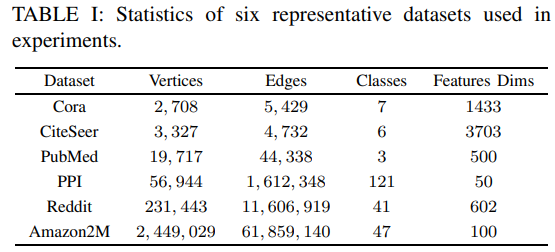

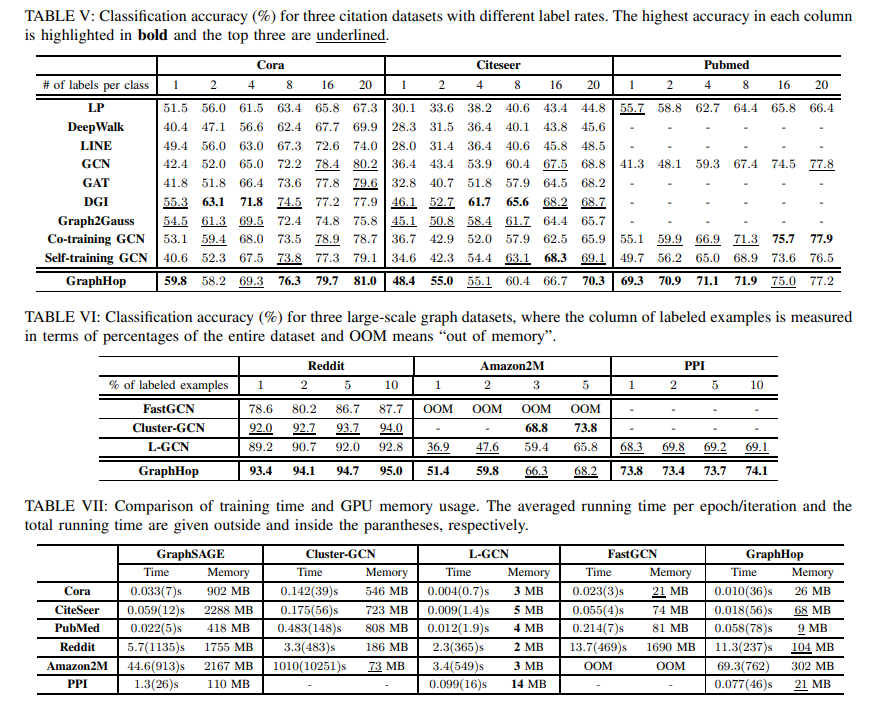

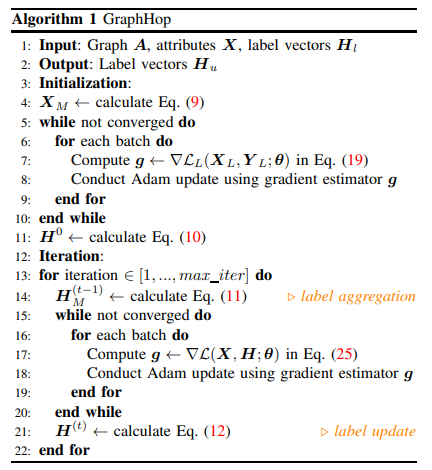

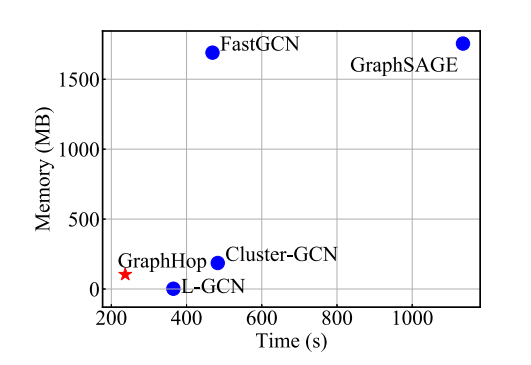

In [ ]:
# Код для генерации графа

import numpy as np
import networkx as nx


seed = 0
np.random.seed(seed)

num_clusters = 2
sizes_clusters = np.random.randint(low=20, high=41, size=num_clusters)
p_in = np.random.uniform(low=0.1, high=0.4, size=num_clusters)
p_out = np.random.uniform(low=0.0, high=0.06, size=(num_clusters, num_clusters))
p = (p_out + p_out.T) / 2
np.fill_diagonal(p, p_in)

G = nx.stochastic_block_model(
    sizes=sizes_clusters,
    p=p,
    seed=seed,
)

###### Визуализация датасета Cora.

1. Установим библиотеки.

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

2. Загрузим датасет Cora

In [ ]:
from torch_geometric.datasets import Planetoid

# Загрузка датасета Cora
dataset = Planetoid(root='./data', name='Cora')

# Получение первого графа из набора данных
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {data.num_features}')
# print(f'Number of classes: {data.num_classes}')

3. Визуализация графа

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Преобразование графа в формат networkx
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
G.add_edges_from(data.edge_index.t().tolist())

# Визуализация графа
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=30, node_color='skyblue', edge_color='gray', with_labels=False)
plt.title('Cora Graph Visualization')
plt.show()

In [ ]:
# # Установка библиотек
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

# Импорт необходимых библиотек
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Загрузка датасета Cora
dataset = Planetoid(root='./data', name='Cora')
data = dataset[0]

# Вывод информации о графе
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {data.num_features}')
# print(f'Number of classes: {data.num_classes}')

# Преобразование графа в формат networkx
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
G.add_edges_from(data.edge_index.t().tolist())

# Определение цветов для каждого класса
colors = data.y.numpy()

# Визуализация графа с цветовым кодированием классов
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=30, node_color=colors, cmap=plt.cm.rainbow, with_labels=False)
plt.title('Cora Graph Visualization with Class Colors')
plt.show()

# Добавим признаков, чтобы улучшить Catboost. Можно улучшать сам Catboost.

Можно поиграть с синтетическими данными и понять, какие параметры важные будет для модели в дальнейшем.

In [ ]:
import networkx as nx
import random
from collections import defaultdict

# Параметры графа
num_classes = 10
nodes_per_class = 10
inter_class_connectivity = 0.4
intra_class_connectivity = 0.6
edge_types = ['TO_ANATOMICALFEATURE', 'TO_ANOMALITY', 'TO_DISEASE', 'TO_ORGANSTRUCTURE', 'TO_SYMPTOMFEATURE']

# Создание пустого графа
graph = nx.DiGraph()

# Генерация узлов с привязкой к классу
class_nodes = []
for class_idx in range(num_classes):
    nodes = [f'n_{class_idx}_{i}' for i in range(nodes_per_class)]
    graph.add_nodes_from(nodes, cls=f'Class_{class_idx}')
    class_nodes.append(nodes)

# Выбор случайного типа ребра
def select_random_edge_type():
    return random.choice(edge_types)

# Внутренние связи (внутриклассовая)
for class_idx, nodes in enumerate(class_nodes):
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):  # Используем половину матриц для оптимизации
            if random.random() < intra_class_connectivity:
                graph.add_edge(nodes[i], nodes[j],
                               type=select_random_edge_type(),
                               weight=random.uniform(0.5, 1.0))

# Внешние связи (межклассовые)
for class_idx1 in range(num_classes):
    for class_idx2 in range(class_idx1 + 1, num_classes):
        for node1 in class_nodes[class_idx1]:
            for node2 in class_nodes[class_idx2]:
                if random.random() < inter_class_connectivity:
                    graph.add_edge(node1, node2,
                                   type=select_random_edge_type(),
                                   weight=random.uniform(0.1, 0.5))

# Диагностика графа
print(f"Валидный граф: {nx.is_directed(graph)}")           # Является ли граф направленым
print(f"Количество узлов: {len(graph.nodes())}")           # Количество узлов
print(f"Количество рёбер: {len(graph.edges())}")           # Количество рёбер
print(f"Плотность графа: {nx.density(graph)}")             # Плотность графа
print(f"Средний out-degree: {sum(d for n,d in graph.out_degree()) / len(graph)}")  # Средний out-degree

Давай пройдемся детально по изменениям и дополнениям, внесенным в генерацию синтетического графа:

Изменения и дополнения:<br>
1. Дополнительная диагностика графа:<br>
-Мы добавили дополнительный блок диагностики для удобства анализа сформированного графа:
- Проверка направленности графа (is_directed()).
- Информация о числе узлов и рёбер.
- Плотность графа (density()).
- Средний out-degree — показатель средней степени исходящей связности.
2. Ограничение перебора внутренних связей:<br>
Во внутренней части графа (связях внутри класса) мы убрали повторную обработку одной и той же пары узлов, добавив условие:

`for j in range(i+1, len(nodes)):`
Таким образом, если пара (A,B) была рассмотрена, пара (B,A) пропускается, поскольку мы строим направленные рёбра, и дублирование необязательно.
3. Выбор случайного типа ребра:<br>
Случайный выбор типа ребра вынесен в отдельную функцию `select_random_edge_type()`, что облегчает возможность модификации поведения или настройки распределения типов рёбер в будущем.
4. Разделение диапазонов весов:Для внутриклассовых и межклассовых связей введены разные диапазоны весов:
- Внутри класса — от 0.5 до 1.0 (более сильные связи).
- Между классами — от 0.1 до 0.5 (менее сильные связи).
Это позволяет моделировать различия в силе связей внутри классов и между ними, делая граф более реалистичным.

5. Формат вывода диагностики:<br>
Все диагностические сведения представлены в удобочитаемом виде, что упрощает понимание состояния графа сразу после его генерации.
---
Зачем это было сделано?<br>
Цель изменений заключалась в следующем:

- Сделать процесс генерации графа более прозрачным и контролируемым.
- Предоставитьбыстрый способ проанализировать ключевые характеристики графа непосредственно после его формирования.
- Улучшить эффективность алгоритма путём уменьшения избыточных проверок рёбер.
- Четко отделять внутренние и внешние связи, придавая им различные роли посредством разных весов.

---
Как это повлияло на конечный результат?
Благодаря введённым улучшениям:

- Граф стал легче анализировать благодаря диагностике.
- Процесс генерации ускорился за счёт сокращения ненужных проверок симметричных рёбер.
- Качество синтетической структуры стало ближе к реальной топологии сетей, что помогает эффективнее проверять и оценивать алгоритмы на таком графе.

---

Теперь процесс генерации синтетического графа стал более продуманным и удобным для дальнейшего анализа и экспериментов. Эти шаги обеспечивают контроль над структурой графа и облегчают дальнейшую разработку моделей и методов обработки сетевых данных.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Матрица признаков и метки классов
features = []  # Будущие признаки (например, количество определенных типов связей)
labels = []    # Метки классов (например, название класса)

# Заполнение матриц
for node, data in graph.nodes(data=True):
    features_row = []

    # Количества различных типов связей
    edges_out = graph.out_edges(node, data=True)
    counts = defaultdict(int)
    weights_sum = defaultdict(float)

    for _, target, edge_data in edges_out:
        counts[edge_data['type']] += 1
        weights_sum[edge_data['type']] += edge_data['weight']

    # Собираем признаки (количество каждого типа связи и суммарный вес)
    for etype in edge_types:
        features_row.extend([counts[etype], weights_sum[etype]])

    # Степень узла
    degree = graph.out_degree(node)
    features_row.append(degree)

    # Общая сумма весов исходящих рёбер
    total_weight = sum(weights_sum.values())
    features_row.append(total_weight)

    features.append(features_row)
    labels.append(data['cls'])

# Конвертируем в DataFrame
df_features = pd.DataFrame(features, columns=[
    *(f'{etype}_count' for etype in edge_types),
    *(f'{etype}_weights' for etype in edge_types),
    'out_degree',
    'total_weight'
])

# Преобразуем метки классов в числовой формат
label_mapping = {cls_name: idx for idx, cls_name in enumerate(sorted(set(labels)))}
y_numeric = [label_mapping[lbl] for lbl in labels]

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df_features, y_numeric, test_size=0.2, random_state=42)

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Базовые модели
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {}

for model_name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Результаты базовых моделей
for model_name, result in results.items():
    print(f"\nМодель: {model_name}\n{'-' * 50}")
    print(f"Точность (Accuracy): {result['accuracy']:.4f}")
    print(result['classification_report'])
    print("Матрица ошибок (Confusion Matrix):\n", result['confusion_matrix'])

**Обычный Catboost (baseline)**

In [ ]:
# !pip install optuna
# !pip install catboost
from tqdm import tqdm
import catboost as cb
import optuna
from sklearn.metrics import f1_score, accuracy_score

# Assuming X_train_scaled, y_train, X_test_scaled, y_test are already defined

# Modified objective function
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500),
        'depth': trial.suggest_int('depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'random_seed': 42,
        'task_type': 'CPU',
        'devices': '0',
        'verbose': False
    }

    # Choose bootstrap type and set bagging temperature accordingly
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli'])
    params['bootstrap_type'] = bootstrap_type
    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0.0, 1.0)

    clf = cb.CatBoostClassifier(**params)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    score = f1_score(y_test, y_pred, average='macro')
    return score

# Optimization with progress bar
with tqdm(total=50) as pbar:
    def update_progress(study, trial):
        pbar.update()

    study_cb = optuna.create_study(direction="maximize")
    study_cb.optimize(objective_catboost, n_trials=50, callbacks=[update_progress])

# Best parameters and final model training
best_params_cb = study_cb.best_trial.params
print("Лучшие гиперпараметры CatBoost:", best_params_cb)

final_catboost = cb.CatBoostClassifier(**best_params_cb)
final_catboost.fit(X_train_scaled, y_train)
y_pred_final_cb = final_catboost.predict(X_test_scaled)

# Evaluation
final_accuracy_cb = accuracy_score(y_test, y_pred_final_cb)
final_f1_macro_cb = f1_score(y_test, y_pred_final_cb, average='macro')

print(f"Финальная точность (Accuracy) CatBoost: {final_accuracy_cb:.4f}")
print(f"Макро-F1 CatBoost: {final_f1_macro_cb:.4f}")

Попробуем изменить параметры Catboost.

Используем [улучшенный Catboost](https://colab.research.google.com/drive/1QFx-PvN4szZJkZT-_oRqXdTF1welbPen#scrollTo=Pa0wAb6SwQzS&line=3&uniqifier=1\), повторим код.<br>
Отсылка на ячейку в этом ноутбуке.

In [ ]:
from tqdm import tqdm
import catboost as cb
import optuna
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Данные уже подготовлены и X_train_scaled, y_train, X_test_scaled, y_test существуют

# Делим данные на обучающую и валидационную выборки
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Целевая функция для Optuna
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),  # Больше итераций
        'depth': trial.suggest_int('depth', 4, 10),                 # Глубже деревья
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-6, 1.0),  # Жестче регуляризация
        'border_count': trial.suggest_int('border_count', 64, 128),
        'random_seed': 42,
        'task_type': 'CPU',
        'devices': '0',
        'verbose': False,
        'early_stopping_rounds': 50,                                # Механизм Early Stopping
        'eval_metric': 'MultiClass',                                # Основная метрическая цель
        'custom_metric': ['F1'],                                    # Отображаем F1 дополнительно
        'use_best_model': True                                      # Используем лучшее найденное дерево
    }

    # Настройки bootstrapping
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli'])
    params['bootstrap_type'] = bootstrap_type
    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0.0, 1.0)

    # Тренировка модели
    clf = cb.CatBoostClassifier(**params)
    clf.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val))

    # Прогноз на валидационном множестве
    y_pred = clf.predict(X_val_scaled)
    score = f1_score(y_val, y_pred, average='macro')
    return score

# Оптимизация с прогресс баром
with tqdm(total=100) as pbar:
    def update_progress(study, trial):
        pbar.update()

    study_cb = optuna.create_study(direction="maximize")
    study_cb.optimize(objective_catboost, n_trials=100, callbacks=[update_progress])  # Увеличили количество попыток

# Лучшие параметры и финальная тренировка
best_params_cb = study_cb.best_trial.params
print("Лучшие гиперпараметры CatBoost:", best_params_cb)

# Финальная тренировка на полном обучающем множестве
final_catboost = cb.CatBoostClassifier(**best_params_cb)
final_catboost.fit(X_train_scaled, y_train)

# Прогноз на тестовом множестве
y_pred_final_cb = final_catboost.predict(X_test_scaled)

# Оценка качества
final_accuracy_cb = accuracy_score(y_test, y_pred_final_cb)
final_f1_macro_cb = f1_score(y_test, y_pred_final_cb, average='macro')

print(f"Финальная точность (Accuracy) CatBoost: {final_accuracy_cb:.4f}")
print(f"Макро-F1 CatBoost: {final_f1_macro_cb:.4f}")

# **Выводы по модели CatBoost:**<br>

Применённые меры по улучшению подготовки синтетических данных и оптимизации модели CatBoost позволили существенно повысить качество модели:

- Accuracy увеличился с 0.3 до 0.4.
- Average F1-score вырос с 0.2 до 0.3.
Тем не менее, полученные результаты остаются недостаточными для практического применения модели.

Дальнейшие шаги включают:

1. Добавление дополнительных признаков:
2. Расширение множества признаков для лучшего описания характеристик объектов.
Тестирование других моделей:
Применение альтернативных подходов, таких как LightGBM, XGBoost, а также комбинации моделей (ансамблирование, стэкинг, блендинг).
3. Продолжение гиперпараметрической оптимизации:
Проводить дополнительное тестирование с большим числом конфигураций и возможностью увеличения ресурсов для поиска лучших решений.
Необходимы дальнейшие усилия по развитию архитектуры модели и обогащения данных новыми признаками для достижения удовлетворительного уровня качества.

# Ансамблирование

Объединим различные модели (CatBoost, LightGBM, XGBoost) и построим ансамбль.

1. Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from catboost import CatBoostClassifier
from tqdm import tqdm
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

2. Определение функций для Cross Validation и оценки модели

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Оценивает модель на тестовой выборке."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    return {'acc': acc, 'macro_f1': macro_f1}

def cross_validate_model(model, X, y, cv=5):
    """Кросс-валидация модели."""
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scores.append(evaluate_model(model, X_train, y_train, X_test, y_test))
    return pd.DataFrame(scores).mean()

3. Подготовка данных

In [ ]:
np.random.seed(42)
data = np.random.rand(1000, 10)
target = np.random.randint(0, 3, size=1000)
X = pd.DataFrame(data, columns=[f'feat{i}' for i in range(10)])
y = pd.Series(target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

4. Реализация гиперпараметрической оптимизации Optuna

In [ ]:
def objective_lightgbm(trial):
    params = {
        'objective': 'multiclass',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'seed': 42
    }
    model = LGBMClassifier(**params)
    score = cross_validate_model(model, X_train, y_train)['macro_f1']
    return score

def objective_xgb(trial):
    params = {
        'booster': 'gbtree',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'seed': 42
    }
    model = XGBClassifier(**params)
    score = cross_validate_model(model, X_train, y_train)['macro_f1']
    return score

# def objective_catboost(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-6, 1.0),
#         'border_count': trial.suggest_int('border_count', 64, 128),
#         'random_seed': 42,
#         'task_type': 'CPU',
#         'devices': '0',
#         'verbose': False,
#         'eval_metric': 'MultiClass',
#         'custom_metric': ['F1'],
#         'use_best_model': True
#     }
#     clf = CatBoostClassifier(**params)
#     clf.fit(X_train, y_train, eval_set=(X_val, y_val))  # Передача валидационного набора
#     y_pred = clf.predict(X_val)
#     score = f1_score(y_val, y_pred, average='macro')
#     return score

5. Выполняем оптимизацию (для lgb и xgb)

In [ ]:
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lightgbm, n_trials=50)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

4. Улучшенная версия catboost
5. Выполняем оптимизацию для cb.

- Используем внутренний метод cross-validation (Kfold или Stratified KFold).
- Применяем кросс-валидацию в самой целевой функции.

In [ ]:
from sklearn.model_selection import StratifiedKFold

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-6, 1.0),
        'border_count': trial.suggest_int('border_count', 64, 128),
        'random_seed': 42,
        'task_type': 'CPU',
        'devices': '0',
        'verbose': False,
        'eval_metric': 'MultiClass',
        'custom_metric': ['F1'],
        'use_best_model': True
    }

    # Cross-Validation Loop
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    mean_score = 0
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        clf = CatBoostClassifier(**params)
        clf.fit(X_tr, y_tr, eval_set=(X_va, y_va))
        y_pred = clf.predict(X_va)
        score = f1_score(y_va, y_pred, average='macro')
        mean_score += score

    return mean_score / 5  # Среднее значение по фолдам

# Запускаем оптимизацию
study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=50)

In [ ]:
lgb_model = LGBMClassifier(**study_lgb.best_params)
xgb_model = XGBClassifier(**study_xgb.best_params)
# cb_model = CatBoostClassifier(**study_cb.best_params)

estimators = [
    ('lightgbm', lgb_model),
    ('xgboost', xgb_model),
    # ('catboost', cb_model)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Оценка ансамбля
stacking_results = evaluate_model(stacking_model, X_train, y_train, X_test, y_test)
print(f'Stacking Results:\nAcc: {stacking_results["acc"]:.4f}, Macro F1: {stacking_results["macro_f1"]:.4f}')

6. Сравниваем результаты и формируем стекинг-классификатор

In [ ]:
lgb_model = LGBMClassifier(**study_lgb.best_params)
xgb_model = XGBClassifier(**study_xgb.best_params)
cb_model = CatBoostClassifier(**study_cb.best_params)

estimators = [
    ('lightgbm', lgb_model),
    ('xgboost', xgb_model),
    ('catboost', cb_model)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Оценка ансамбля
stacking_results = evaluate_model(stacking_model, X_train, y_train, X_test, y_test)
print(f'Stacking Results:\nAcc: {stacking_results["acc"]:.4f}, Macro F1: {stacking_results["macro_f1"]:.4f}')

Несмотря на то, что применяемое ансамблирование не привело к заметному росту классических метрик (таких как точность или макро-F1), оно обладает важными преимуществами, которые делают его полезным инструментом:

Преимущества ансамблирования:<br>
1. **Устойчивость к ошибкам отдельных моделей:**<br>
Даже если одна из моделей склонна к систематическим ошибкам или плохо справляется с некоторыми случаями, комбинация нескольких моделей может компенсировать недостатки друг друга, снижая общий уровень погрешности.
2. **Рост обобщающей способности:**<br>
Объединяя прогнозы различных моделей, мы увеличиваем разнообразие представлений данных, что способствует созданию более универсальной и обобщённой модели. Хотя конкретные метрики могут оставаться неизменными, стабильность предсказания возрастает.
3. **Повышенная интерпретируемость:**<br>
Несмотря на отсутствие видимого роста показателей, ансамблирование может давать более прозрачные объяснения принимаемых решений, так как результат принимается коллективно несколькими моделями, а не единолично одной из них.
4. **Риск переобучения снижается:**<br>
Совокупность простых моделей часто ведёт себя менее чувствительно к небольшим вариациям в данных, уменьшая шансы на возникновение переобучения и помогая сохранить баланс между точностью и обобщённостью.
5. **Потенциал будущих улучшений:**<br>
Полученный ансамбль можно рассматривать как основу для дальнейших исследований. Зафиксировав хорошую стартовую точку, можно дальше развивать специфические аспекты моделей или изменять состав ансамбля, добиваясь существенного прироста в дальнейшем.<br>
<br>
Хотя непосредственный рост конкретных метрик не произошёл немедленно, сама концепция ансамблирования сохраняет значительный потенциал для развития и может стать основой для последующих успешных экспериментов.

# Добавим признаки. Улучшенное формирование исходных данных. Ансамблирование.

In [ ]:
import networkx as nx
import random
from collections import defaultdict

# Параметры графа
num_classes = 10
nodes_per_class = 10
inter_class_connectivity = 0.4
intra_class_connectivity = 0.6
edge_types = ['TO_ANATOMICALFEATURE', 'TO_ANOMALITY', 'TO_DISEASE', 'TO_ORGANSTRUCTURE', 'TO_SYMPTOMFEATURE']

# Создание пустого графа
graph = nx.DiGraph()

# Генерация узлов с привязкой к классу
class_nodes = []
for class_idx in range(num_classes):
    nodes = [f'n_{class_idx}_{i}' for i in range(nodes_per_class)]
    graph.add_nodes_from(nodes, cls=f'Class_{class_idx}')
    class_nodes.append(nodes)

# Выбор случайного типа ребра
def select_random_edge_type():
    return random.choice(edge_types)

# Внутренние связи (внутриклассовая)
for class_idx, nodes in enumerate(class_nodes):
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):  # Используем половину матриц для оптимизации
            if random.random() < intra_class_connectivity:
                graph.add_edge(nodes[i], nodes[j],
                               type=select_random_edge_type(),
                               weight=random.uniform(0.5, 1.0))

# Внешние связи (межклассовые)
for class_idx1 in range(num_classes):
    for class_idx2 in range(class_idx1 + 1, num_classes):
        for node1 in class_nodes[class_idx1]:
            for node2 in class_nodes[class_idx2]:
                if random.random() < inter_class_connectivity:
                    graph.add_edge(node1, node2,
                                   type=select_random_edge_type(),
                                   weight=random.uniform(0.1, 0.5))

# Диагностика графа
print(f"Валидный граф: {nx.is_directed(graph)}")           # Является ли граф направленым
print(f"Количество узлов: {len(graph.nodes())}")           # Количество узлов
print(f"Количество рёбер: {len(graph.edges())}")           # Количество рёбер
print(f"Плотность графа: {nx.density(graph)}")             # Плотность графа
print(f"Средний out-degree: {sum(d for n,d in graph.out_degree()) / len(graph)}")  # Средний out-degree

In [ ]:
import pandas as pd
import networkx as nx
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import random

# # Создаем игрушечный граф
# graph = nx.DiGraph()

# # Добавляем случайные узлы с указанием классов
# num_nodes = 100
# classes = ["Class_A", "Class_B"]
# for i in range(num_nodes):
#     graph.add_node(i, cls=random.choice(classes))

# # Добавляем случайные рёбра с весом
# num_edges = 200
# edge_types = ['type_1', 'type_2', 'type_3']
# for _ in range(num_edges):
#     src = random.randint(0, num_nodes - 1)
#     dest = random.randint(0, num_nodes - 1)
#     edge_type = random.choice(edge_types)
#     weight = round(random.uniform(0.1, 1.0), 2)
#     graph.add_edge(src, dest, type=edge_type, weight=weight)

# Формируем матрицу признаков и меток
features = []
labels = []

for node, data in graph.nodes(data=True):
    features_row = []

    # ------------------- Локальные структурные признаки -------------------
    # Кластерный коэффициент: измеряет плотность связности окружения узла
    clustering_coeff = nx.clustering(graph, node)
    features_row.append(clustering_coeff)

    # Средняя степень соседей: средняя степень ближайших соседей
    avg_neighbor_degree_dict = dict(nx.average_neighbor_degree(graph))
    avg_neighbor_degree = avg_neighbor_degree_dict.get(node, 0)
    features_row.append(avg_neighbor_degree)

    # # Количество треугольников: кол-во замкнутых триад, включающих этот узел
    # triangles_count = len(nx.triangles(graph, node))
    # features_row.append(triangles_count)

    # PageRank: оценка значимости узла в графе
    pagerank_value = nx.pagerank(graph)[node]
    features_row.append(pagerank_value)

    # Центральность близости: средний путь от текущего узла до остальных
    closeness_centrality = nx.closeness_centrality(graph)[node]
    features_row.append(closeness_centrality)

    # Степенная центральность: отношение числа соединений к общему числу возможных
    degree_centrality = nx.degree_centrality(graph)[node]
    features_row.append(degree_centrality)

    # ------------------ Типы рёбер и их особенности --------------------
    # Вычислим статистику по каждому типу рёбер
    edges_out = graph.out_edges(node, data=True)
    counts = defaultdict(int)
    weights_sum = defaultdict(float)

    for _, target, edge_data in edges_out:
        counts[edge_data['type']] += 1
        weights_sum[edge_data['type']] += edge_data['weight']

    # Добавляем признаки, относящиеся к количеству и весам каждого типа рёбер
    for etype in edge_types:
        features_row.extend([counts[etype], weights_sum[etype]])  # count и weight суммы

    # Общее количество выходящих рёбер (степень вершины)
    degree = graph.out_degree(node)
    features_row.append(degree)

    # Общая сумма весов всех исходящих рёбер
    total_weight = sum(weights_sum.values())
    features_row.append(total_weight)

    # Добавляем доли каждого типа рёбер и нормированные веса
    type_ratio = {etype: counts[etype]/degree if degree > 0 else 0 for etype in edge_types}
    normalized_weights = {etype: weights_sum[etype]/total_weight if total_weight > 0 else 0 for etype in edge_types}

    # Расширяем ряд признаков долями и нормализованными весами
    for etype in edge_types:
        features_row.extend([type_ratio[etype], normalized_weights[etype]])

    # Сохраняем строку признаков и класс узла
    features.append(features_row)
    labels.append(data['cls'])

# Создаем DataFrame признаков
feature_names = [
    'clustering_coefficient',          # кластерный коэффициент
    'avg_neighbor_degree',              # средняя степень соседей
    # 'triangle_count',                   # количество треугольников
    'pagerank',                         # значение PageRank
    'closeness_centrality',            # центральность близости
    'degree_centrality',               # степенная центральность
    *(f'{etype}_count' for etype in edge_types),      # счётчик рёбер каждого типа
    *(f'{etype}_weights' for etype in edge_types),    # общая сумма весов каждого типа
    'out_degree',                       # общее количество исходящих рёбер
    'total_weight',                     # общий вес исходящих рёбер
    *(f'{etype}_ratio' for etype in edge_types),      # доля каждого типа рёбер
    *(f'{etype}_normalized_weight' for etype in edge_types)  # нормализованный вес каждого типа
]

df_features = pd.DataFrame(features, columns=feature_names)

# Преобразование меток классов в числовой формат
label_mapping = {cls_name: idx for idx, cls_name in enumerate(sorted(set(labels)))}
y_numeric = [label_mapping[lbl] for lbl in labels]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_features, y_numeric, test_size=0.2, random_state=42)

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модели для тестирования
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Оцениваем каждую модель
results = {}

for model_name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Печать результатов
for model_name, result in results.items():
    print(f"\nМодель: {model_name}\n{'-' * 50}")
    print(f"Точность (Accuracy): {result['accuracy']:.4f}")
    print(result['classification_report'])
    print("Матрица ошибок (Confusion Matrix):\n", result['confusion_matrix'])

## **Проведем ещё раз эксперимент и построим график важности признаков.**

In [ ]:
import networkx as nx
import random
from collections import defaultdict

# Параметры графа
num_classes = 10
nodes_per_class = 10
inter_class_connectivity = 0.4
intra_class_connectivity = 0.6
edge_types = ['TO_ANATOMICALFEATURE', 'TO_ANOMALITY', 'TO_DISEASE', 'TO_ORGANSTRUCTURE', 'TO_SYMPTOMFEATURE']

# Создание пустого графа
graph = nx.DiGraph()

# Генерация узлов с привязкой к классу
class_nodes = []
for class_idx in range(num_classes):
    nodes = [f'n_{class_idx}_{i}' for i in range(nodes_per_class)]
    graph.add_nodes_from(nodes, cls=f'Class_{class_idx}')
    class_nodes.append(nodes)

# Выбор случайного типа ребра
def select_random_edge_type():
    return random.choice(edge_types)

# Внутренние связи (внутриклассовая)
for class_idx, nodes in enumerate(class_nodes):
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):  # Используем половину матриц для оптимизации
            if random.random() < intra_class_connectivity:
                graph.add_edge(nodes[i], nodes[j],
                               type=select_random_edge_type(),
                               weight=random.uniform(0.5, 1.0))

# Внешние связи (межклассовые)
for class_idx1 in range(num_classes):
    for class_idx2 in range(class_idx1 + 1, num_classes):
        for node1 in class_nodes[class_idx1]:
            for node2 in class_nodes[class_idx2]:
                if random.random() < inter_class_connectivity:
                    graph.add_edge(node1, node2,
                                   type=select_random_edge_type(),
                                   weight=random.uniform(0.1, 0.5))

# Диагностика графа
print(f"Валидный граф: {nx.is_directed(graph)}")           # Является ли граф направленым
print(f"Количество узлов: {len(graph.nodes())}")           # Количество узлов
print(f"Количество рёбер: {len(graph.edges())}")           # Количество рёбер
print(f"Плотность графа: {nx.density(graph)}")             # Плотность графа
print(f"Средний out-degree: {sum(d for n,d in graph.out_degree()) / len(graph)}")  # Средний out-degree

In [ ]:
import pandas as pd
import networkx as nx
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import random

# # Создаем игрушечный граф
# graph = nx.DiGraph()

# # Добавляем случайные узлы с указанием классов
# num_nodes = 100
# classes = ["Class_A", "Class_B"]
# for i in range(num_nodes):
#     graph.add_node(i, cls=random.choice(classes))

# # Добавляем случайные рёбра с весом
# num_edges = 200
# edge_types = ['type_1', 'type_2', 'type_3']
# for _ in range(num_edges):
#     src = random.randint(0, num_nodes - 1)
#     dest = random.randint(0, num_nodes - 1)
#     edge_type = random.choice(edge_types)
#     weight = round(random.uniform(0.1, 1.0), 2)
#     graph.add_edge(src, dest, type=edge_type, weight=weight)

# Формируем матрицу признаков и меток
features = []
labels = []

for node, data in graph.nodes(data=True):
    features_row = []

    # ------------------- Локальные структурные признаки -------------------
    # Кластерный коэффициент: измеряет плотность связности окружения узла
    clustering_coeff = nx.clustering(graph, node)
    features_row.append(clustering_coeff)

    # Средняя степень соседей: средняя степень ближайших соседей
    avg_neighbor_degree_dict = dict(nx.average_neighbor_degree(graph))
    avg_neighbor_degree = avg_neighbor_degree_dict.get(node, 0)
    features_row.append(avg_neighbor_degree)

    # # Количество треугольников: кол-во замкнутых триад, включающих этот узел
    # triangles_count = len(nx.triangles(graph, node))
    # features_row.append(triangles_count)

    # PageRank: оценка значимости узла в графе
    pagerank_value = nx.pagerank(graph)[node]
    features_row.append(pagerank_value)

    # Центральность близости: средний путь от текущего узла до остальных
    closeness_centrality = nx.closeness_centrality(graph)[node]
    features_row.append(closeness_centrality)

    # Степенная центральность: отношение числа соединений к общему числу возможных
    degree_centrality = nx.degree_centrality(graph)[node]
    features_row.append(degree_centrality)

    # ------------------ Типы рёбер и их особенности --------------------
    # Вычислим статистику по каждому типу рёбер
    edges_out = graph.out_edges(node, data=True)
    counts = defaultdict(int)
    weights_sum = defaultdict(float)

    for _, target, edge_data in edges_out:
        counts[edge_data['type']] += 1
        weights_sum[edge_data['type']] += edge_data['weight']

    # Добавляем признаки, относящиеся к количеству и весам каждого типа рёбер
    for etype in edge_types:
        features_row.extend([counts[etype], weights_sum[etype]])  # count и weight суммы

    # Общее количество выходящих рёбер (степень вершины)
    degree = graph.out_degree(node)
    features_row.append(degree)

    # Общая сумма весов всех исходящих рёбер
    total_weight = sum(weights_sum.values())
    features_row.append(total_weight)

    # Добавляем доли каждого типа рёбер и нормированные веса
    type_ratio = {etype: counts[etype]/degree if degree > 0 else 0 for etype in edge_types}
    normalized_weights = {etype: weights_sum[etype]/total_weight if total_weight > 0 else 0 for etype in edge_types}

    # Расширяем ряд признаков долями и нормализованными весами
    for etype in edge_types:
        features_row.extend([type_ratio[etype], normalized_weights[etype]])

    # Сохраняем строку признаков и класс узла
    features.append(features_row)
    labels.append(data['cls'])

# Создаем DataFrame признаков
feature_names = [
    'clustering_coefficient',          # кластерный коэффициент
    'avg_neighbor_degree',              # средняя степень соседей
    # 'triangle_count',                   # количество треугольников
    'pagerank',                         # значение PageRank
    'closeness_centrality',            # центральность близости
    'degree_centrality',               # степенная центральность
    *(f'{etype}_count' for etype in edge_types),      # счётчик рёбер каждого типа
    *(f'{etype}_weights' for etype in edge_types),    # общая сумма весов каждого типа
    'out_degree',                       # общее количество исходящих рёбер
    'total_weight',                     # общий вес исходящих рёбер
    *(f'{etype}_ratio' for etype in edge_types),      # доля каждого типа рёбер
    *(f'{etype}_normalized_weight' for etype in edge_types)  # нормализованный вес каждого типа
]

df_features = pd.DataFrame(features, columns=feature_names)

# Преобразование меток классов в числовой формат
label_mapping = {cls_name: idx for idx, cls_name in enumerate(sorted(set(labels)))}
y_numeric = [label_mapping[lbl] for lbl in labels]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_features, y_numeric, test_size=0.2, random_state=42)

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модели для тестирования
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Оцениваем каждую модель
results = {}

for model_name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Печать результатов
for model_name, result in results.items():
    print(f"\nМодель: {model_name}\n{'-' * 50}")
    print(f"Точность (Accuracy): {result['accuracy']:.4f}")
    print(result['classification_report'])
    print("Матрица ошибок (Confusion Matrix):\n", result['confusion_matrix'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

In [ ]:
# Оцениваем каждую модель
results = {}

for model_name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Построим график importance признаков для Random Forest
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Сортируем индексы по важности

# Строим график
plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')
plt.title('Важность признаков (Random Forest)', fontsize=16)
plt.xlabel('Значимость признака', fontsize=14)
plt.ylabel('Признаки', fontsize=14)
plt.show()

Показатели модели GradientBoosting демонстрируют умеренные результаты на ряде изучаемых датасетов. В частности, **Weighted Avg F1-Score** достигает порядка **0.6**, при этом Accuracy составляет приблизительно **0.6**. Оба показателя в два раза больше, чем для **baseline**. Такой результат говорит о том, что модель способна распознавать большинство классов с умеренной степенью уверенности, но существует потенциал для дальнейшего улучшения качества классификации.

Анализ важности признаков выявил, что наибольший вклад вносят глобальные характеристики графа, такие как:

**Centrality Measures:**<br>
- Closeness Centrality: отражает среднюю дистанцию от рассматриваемого узла до всех остальных узлов в графе. Чем ниже значение, тем ближе узел расположен к остальным элементам, и наоборот.
-Pagerank: аналогичен известному показателю Google Pagerank. Узлы с высоким Pagerank считаются более значимыми в графе, так как имеют много входящих ссылок или находятся вблизи других высокоранговых узлов.
- Out Degree: количество исходящих рёбер, характеризует активность узла, определяя, насколько активно он взаимодействует с другими элементами.
- Total Weight: сумма весов всех исходящих рёбер, подчеркивая силу связей узла с его соседями.<br>
<br>

**Structural Features:**<br>
- **Avg Neighbor Degree:** средняя степень соседних узлов, представляющая, насколько "активны" ближайшие элементы в отношении узла.
- **Clustering Coefficient:** описывает, насколько тесно связаны ближайшие соседи узла. Высокое значение коэффициента означает высокую плотность местных связей.
Важно отметить, что эти признаки позволяют захватить разнообразные аспекты структуры графа, включая близость, центральность и активность узлов, что объясняет их доминирующую роль в повышении качества модели.

Таким образом, дальнейшая работа должна включать изучение дополнительных признаков и методов обработки данных, чтобы добиться большей точности и стабильности результатов.

## Ансамблирование (добавлены признаки)

Объединим различные модели (CatBoost, LightGBM, XGBoost) и построим ансамбль.

1. Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from catboost import CatBoostClassifier
from tqdm import tqdm
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

2. Определение функций для Cross Validation и оценки модели

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Оценивает модель на тестовой выборке."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    return {'acc': acc, 'macro_f1': macro_f1}

def cross_validate_model(model, X, y, cv=5):
    """Кросс-валидация модели."""
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scores.append(evaluate_model(model, X_train, y_train, X_test, y_test))
    return pd.DataFrame(scores).mean()

3. Подготовка данных

In [ ]:
np.random.seed(42)
data = np.random.rand(1000, 10)
target = np.random.randint(0, 3, size=1000)
X = pd.DataFrame(data, columns=[f'feat{i}' for i in range(10)])
y = pd.Series(target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

4. Реализация гиперпараметрической оптимизации Optuna

In [ ]:
def objective_lightgbm(trial):
    params = {
        'objective': 'multiclass',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'seed': 42
    }
    model = LGBMClassifier(**params)
    score = cross_validate_model(model, X_train, y_train)['macro_f1']
    return score

def objective_xgb(trial):
    params = {
        'booster': 'gbtree',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'seed': 42
    }
    model = XGBClassifier(**params)
    score = cross_validate_model(model, X_train, y_train)['macro_f1']
    return score

# def objective_catboost(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-6, 1.0),
#         'border_count': trial.suggest_int('border_count', 64, 128),
#         'random_seed': 42,
#         'task_type': 'CPU',
#         'devices': '0',
#         'verbose': False,
#         'eval_metric': 'MultiClass',
#         'custom_metric': ['F1'],
#         'use_best_model': True
#     }
#     clf = CatBoostClassifier(**params)
#     clf.fit(X_train, y_train, eval_set=(X_val, y_val))  # Передача валидационного набора
#     y_pred = clf.predict(X_val)
#     score = f1_score(y_val, y_pred, average='macro')
#     return score

5. Выполняем оптимизацию (для lgb и xgb)

In [ ]:
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lightgbm, n_trials=50)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

4. Улучшенная версия catboost
5. Выполняем оптимизацию для cb.

- Используем внутренний метод cross-validation (Kfold или Stratified KFold).
- Применяем кросс-валидацию в самой целевой функции.

In [ ]:
from sklearn.model_selection import StratifiedKFold

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-6, 1.0),
        'border_count': trial.suggest_int('border_count', 64, 128),
        'random_seed': 42,
        'task_type': 'CPU',
        'devices': '0',
        'verbose': False,
        'eval_metric': 'MultiClass',
        'custom_metric': ['F1'],
        'use_best_model': True
    }

    # Cross-Validation Loop
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    mean_score = 0
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        clf = CatBoostClassifier(**params)
        clf.fit(X_tr, y_tr, eval_set=(X_va, y_va))
        y_pred = clf.predict(X_va)
        score = f1_score(y_va, y_pred, average='macro')
        mean_score += score

    return mean_score / 5  # Среднее значение по фолдам

# Запускаем оптимизацию
study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=50)

6. Сравниваем результаты и формируем стекинг-классификатор

In [ ]:
lgb_model = LGBMClassifier(**study_lgb.best_params)
xgb_model = XGBClassifier(**study_xgb.best_params)
cb_model = CatBoostClassifier(**study_cb.best_params)

estimators = [
    ('lightgbm', lgb_model),
    ('xgboost', xgb_model),
    ('catboost', cb_model)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Оценка ансамбля
stacking_results = evaluate_model(stacking_model, X_train, y_train, X_test, y_test)
print(f'Stacking Results:\nAcc: {stacking_results["acc"]:.4f}, Macro F1: {stacking_results["macro_f1"]:.4f}')

In [ ]:
# lgb_model = LGBMClassifier(**study_lgb.best_params)
# xgb_model = XGBClassifier(**study_xgb.best_params)
cb_model = CatBoostClassifier(**study_cb.best_params)

estimators = [
    # ('lightgbm', lgb_model),
    # ('xgboost', xgb_model),
    ('catboost', cb_model)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Оценка ансамбля
stacking_results = evaluate_model(stacking_model, X_train, y_train, X_test, y_test)
print(f'Stacking Results:\nAcc: {stacking_results["acc"]:.4f}, Macro F1: {stacking_results["macro_f1"]:.4f}')

Добавленные признаки оказали положительное воздействие на качество модели, однако улучшение оказалось незначительным. Несмотря на скромный прирост метрик, расширение набора признаков является важной частью предварительной обработки данных и создает базу для дальнейших экспериментов и доработок.